In [1]:
import mturk
import random
from datetime import datetime
import json
from pprint import pprint
import copy
import numpy as np
from collections import OrderedDict
import pandas as pd
import pymongo
import botocore
import uuid
import pdb
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import krippendorff_alpha as ka

In [2]:
with open('../config/mongodb_credentials.json','r') as f:
    mongodb_credentials = json.load(f)

In [3]:
""" Connect to MTurk and to the Mongodb database. Set the boolean below to TRUE to use the marketplace and to FALSE to use the sandbox (testing the HITs)"""
create_hits_in_production = True
is_pilot = True

db_client = pymongo.MongoClient(mongodb_credentials["connection_string"])
db = db_client['textual_entailment']

collection_name = 'hit_results' + ('_sandbox' if not create_hits_in_production else '') + ('_pilots' if is_pilot else '')

hit_result_collection = db[collection_name]
hit_result_collection

Collection(Database(MongoClient(host=['cluster0-shard-00-02.hjstc.mongodb.net:27017', 'cluster0-shard-00-01.hjstc.mongodb.net:27017', 'cluster0-shard-00-00.hjstc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='Cluster0-shard-0', ssl=True), 'textual_entailment'), 'hit_results_pilots')

# Analysing Pilot results

Remember to reward good feedback

In [4]:
from pprint import pprint
batch_pipeline = [
    {
        '$project': {
            'batch_id': 1, 
            'type': 1, 
            'scale': 1, 
            'hit': 1, 
            'timestamp': 1
        }
    }, {
        '$group': {
            '_id': '$batch_id', 
            'type': {
                '$max': '$type'
            }, 
            'scale': {
                '$max': '$scale'
            }, 
            'timestamp': {
                '$min': '$timestamp'
            }, 
            'ids': {
                '$addToSet': '$_id'
            }, 
            'reward': {
                '$avg': {
                    '$toDouble': '$hit.Reward'
                }
            }
        }
    }, {
        '$addFields': {
            'count': {
                '$size': '$ids'
            }
        }
    }
]
pprint(list(hit_result_collection.aggregate(batch_pipeline)))

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[{'_id': '21fe930d-5bb6-491e-afbb-ab0bbf1b90aa',
  'count': 23,
  'ids': ['3YLPJ8OXYBPU4YC7TBD7OGDSJU64X4',
          '35JDMRECD7L1AEEAT7PG9GPOTT4EGS',
          '3MJ9GGZYP6I857PREN25BT5WYV12A2',
          '3FJ2RVH262IU0OFMMHO5FYUCSDJ29N',
          '3421H3BMADTU6KDUT2UXEFGTUO5J9R',
          '359AP8GAHJW3KNJV4DFRDFCS9E8C7U',
          '309D674SI2XQMZMLHUR7IHYOS4ZCBG',
          '3909MD9T32TVWEIFINJYRVPCSE4EFT',
          '3X7837UUBGA7O1BWVVRLU5PR4NXJ6G',
          '3FTID4TN9OAF2B924ZYQTBMC7MVLYK',
          '3KTCJ4SCWJD2INGKSMSWF1QR06CM1P',
          '3H1C3QRA14VOT2Y5RLTXJP49V1CECI',
          '3TC2K6WKAJEUMJWCHPIRF2Z187128Y',
          '3R5LWXWHS3KAGE5ROCF8X5AV9ZFGX3',
          '39N6W9XWSGZZGJV1T81AGJH4B59GY9',
          '3IV1AEQ4EUPUSFUKOAOJEJLIAINJ82',
          '30OITAWPCTFYFEI452RC220EHW19HC',
          '3TRB893CTMMG1ZZ06ZBA36X77607GZ',
          '3G9UA71JWY6QS1P1E5WD0JPNZYHJ7F',
          '31HLTCK4CO7ICP0WOXEQ9KDATO7GV0',
          '3S37Y8CWJBCFFY7HJ6HLMXZLAS04WB',
          '3

### Batch ids

#### First run

27 tasks:
- 23 single evidence (100 pairs total, 92 non-gd, 8 gd)
- 4 multiple evidence (20 pairs total (100/5), 16 non-gd, 4 gd)

Single evidence batch id: 21fe930d-5bb6-491e-afbb-ab0bbf1b90aa
    
Multiple evidence batch id: 29210988-a1d8-426c-92c7-d698f8929218

In [5]:
pilot_sing = list(hit_result_collection.find(
    {'type':'single', 'batch_id' : {
        '$in' : ['21fe930d-5bb6-491e-afbb-ab0bbf1b90aa']
    }}))
pilot_mult = list(hit_result_collection.find(
    {'type':'multiple', 'batch_id' : {
        '$in' : ['29210988-a1d8-426c-92c7-d698f8929218']
    }}))

TASK_HITS = {
    'single' : pilot_sing,
    'multiple' : pilot_mult
}
TASK_TYPES = list(TASK_HITS.keys())


len(pilot_sing), len(pilot_mult)

(23, 4)

### "Not Sure - Other" reasons

In [6]:
reason_not_sure_other = {x : [] for x in TASK_TYPES}

for task_type in TASK_TYPES:
    #print(task_type)
    #print(len(TASK_HITS[task_type]))
    for i, hit in enumerate(TASK_HITS[task_type]):
        #print(task_type, i)
        for answer in hit['answers']:
            for output in answer['values']['outputs']:
                if output['reason_not_sure_other'] != '':
                    reason_not_sure_other[task_type].append(output['reason_not_sure_other'])                    
reason_not_sure_other

# EMPTY

{'single': ['Part of the highlighted text supports the affirmation, but, the Irish detail finds no evidence.',
  'The statement is only partly supported by the highlighted text.'],
 'multiple': ["creation date is not mentioned in any of the passages even if the website mentions it. the underlined texts do not completely support the statement, so I have to select 'not sure'."]}

### Completion time

In [7]:
df_pilot_times = {
    'type': [],
    'time': []
}

for task_type in TASK_TYPES:    
    #print(task_type)
    #print(len(TASK_HITS[task_type]))
    for hit in TASK_HITS[task_type]:
        for answer in hit['answers']:
            df_pilot_times['type'].append(task_type)
            df_pilot_times['time'].append(np.sum(answer['values']['times'])/1000)
            
df_pilot_times = pd.DataFrame(df_pilot_times)

for task_type in TASK_TYPES: 
    print(df_pilot_times[df_pilot_times['type'] == task_type]['time'].mean(), f'seconds is the mean {task_type} task time')
    print(df_pilot_times[df_pilot_times['type'] == task_type]['time'].median(), f'seconds is the median {task_type} task time')

349.4935304347828 seconds is the mean single task time
134.499 seconds is the median single task time
563.77425 seconds is the mean multiple task time
348.0005 seconds is the median multiple task time


In [8]:
# According to median values, pay should be
MINIMUM_HOURLY_USD_WAGE = 7.25
for task_type in TASK_TYPES:    
    avg_hit_time_seconds = df_pilot_times[df_pilot_times['type'] == task_type]['time'].median()
    avg_hit_time_hours = avg_hit_time_seconds/3600
    print(f'{task_type}: USD', avg_hit_time_hours*MINIMUM_HOURLY_USD_WAGE)

# I have then decided to pay 0.50 for Single and 1.00 for Multiple, which is above minimum wage, and based on feedback from
# the pilot (see below)

single: USD 0.2708660416666666
multiple: USD 0.7008343402777778


In [9]:
df_pilot_times.sort_values('time')#.head(100)

,type,time
13,single,29.243
110,single,32.459
50,single,37.226
79,single,43.118
83,single,43.366
...,...,...
74,single,2020.761
112,single,2934.084
35,single,3335.253
37,single,3361.460


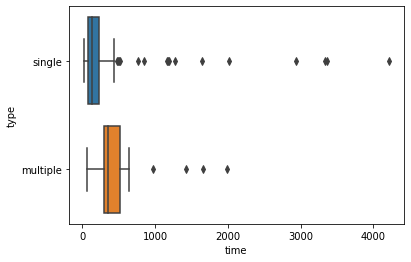

In [10]:
g = sns.boxplot(data = df_pilot_times, x='time', y='type')
g.set_xscale("linear")

### Feedback

In [11]:
USELESS_FEEDBACK = [
    'NICE', 'NOTHING', 'NONE', 'GREAT', 'VERY NICE'
]

from pprint import pprint
for task_type in TASK_TYPES:
    print('-'*10, task_type, '-'*10, '\n')
    for hit in TASK_HITS[task_type]:
        for a in hit['answers']:
            if a['values']['feedback'] != None :
                if not a['values']['feedback'].upper() in USELESS_FEEDBACK:
                    print('Hit _id:', hit['_id'])
                    print('Worker ID:', a['worker_id'])
                    print('Assignment ID:', a['assignment_id'])
                    print(a['values']['feedback'])
                    print('-----')
                    print('\n')
                
# Feedback applied!

---------- single ---------- 

Hit _id: 359AP8GAHJW3KNJV4DFRDFCS9E8C7U
Worker ID: AM65LGXJBTJ0I
Assignment ID: 32Z9ZLUT1PW49LK4XTFWOCRW57RHOD
Everything went well, thank you!
-----


Hit _id: 3R4QIDVOKSO3Q0IJNCZS9D4CGDPEEB
Worker ID: A3APKUC67F9IMW
Assignment ID: 3I0BTBYZA1X5SZIA58H9KBQHX0NY02
They were mostly all unrelated. Maybe have some valid work to test things out.
-----


Hit _id: 3TC2K6WKAJEUMJWCHPIRF2Z187128Y
Worker ID: AKQAI78JTXXC9
Assignment ID: 3LRKMWOKB9TCTZVTGHN6H6SY0SC2ZI
pay's a bit on the low side for actual "knowledge" work versus the usual mindless stuff on here.  i'd recommend 2x the original pay per HIT
-----


Hit _id: 3TC2K6WKAJEUMJWCHPIRF2Z187128Y
Worker ID: ADC4VXNQJ9FEW
Assignment ID: 3WMINLGALFFOQ9FN1IWDCQAB3YICA0
Thank you for the challenging task.
-----


Hit _id: 31HLTCK4CO7ICP0WOXEQ9KDATO7GV0
Worker ID: A2KOXR5OXIFUIW
Assignment ID: 3X65QVEQI4Z5MS6RY9L3L4QMXAHCLI
passage says" John is the team leader. "He lives in USA." where 'he lives in usa' is highlig

### Values

In [12]:
from pprint import pprint

pilot_results_single = {
    'claim_id': [],
    'affirmation': [],
    'reference_id': [],
    'reference_url': [],
    'evidence_id': [],
    'sentence_id': [],
    'evidence': [],
    'score': [],
    'worker_id': [],
    'assignment_id': [],
    'relation': [],
    'reason_not_sure': [],
    'reason_not_sure_other': [],
    'times': []
}

for hit in TASK_HITS['single']:
    try:
        assert len(hit['answers']) == 5
        for answer in hit['answers']:
            for i, _ in enumerate(answer['values']['outputs']):
                subtask_info = hit['verbalisations'][i]
                pilot_results_single['claim_id'].append(subtask_info['claim_id'])
                pilot_results_single['reference_id'].append(subtask_info['reference_id'])
                pilot_results_single['reference_url'].append(subtask_info['reference_url'])
                pilot_results_single['evidence_id'].append(subtask_info['evidence_id'])
                pilot_results_single['sentence_id'].append(subtask_info['sentence_id'])
                pilot_results_single['score'].append(subtask_info['score'])
                pilot_results_single['affirmation'].append(subtask_info['affirmation'])
                pilot_results_single['evidence'].append(subtask_info['evidence'])

                pilot_results_single['worker_id'].append(answer['worker_id'])
                pilot_results_single['assignment_id'].append(answer['assignment_id'])

                pilot_results_single['relation'].append(answer['values']['outputs'][i]['relation'])
                pilot_results_single['reason_not_sure'].append(answer['values']['outputs'][i]['reason_not_sure'])
                pilot_results_single['reason_not_sure_other'].append(answer['values']['outputs'][i]['reason_not_sure_other'])

                pilot_results_single['times'].append(answer['values']['times'][i])
    except Exception:
        print(hit['_id'])
        continue


pilot_results_single_df = pd.DataFrame(pilot_results_single)
assert pilot_results_single_df.shape[0] / 6 / 5 == len(TASK_HITS['single'])
pilot_results_single_df.head()

,claim_id,affirmation,reference_id,reference_url,evidence_id,sentence_id,evidence,score,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
0,Q15954086$76037A29-7519-4DDD-8574-C6E49FD1D471,"Église Sainte-Croix, Kaysersberg is located in...",62eec2975ba36bcf75d8b1f7f69fdac1b5ae2223,https://www.archinform.net/entry.htm?ID=aqrb6m...,0,10;11,The Église de l′Invention de la Sainte-Croix (...,0.999851,A2ZGZQDUKF2B4G,3AWETUDC964G4K9V5K8Y4MZFPO8ZIP,0,-1,,141168
1,Q5634894$AC3C6604-65A6-4D0A-AB48-85A824FBCB68,HMS Wakeful has a length of 44.43 metres.,e702edc73a8a2da974fb2066c3dc4091b85fe376,https://www.vesseltracking.net/ship/aegean-pel...,1,27;28,Length (m) 44.43. Beam (m) 10.65.,0.065445,A2ZGZQDUKF2B4G,3AWETUDC964G4K9V5K8Y4MZFPO8ZIP,0,-1,,11077
2,Q27041785$DCF8C3E4-E0A3-4D62-BEF5-5AFED48A168B,MBK Rieker Komárno won the 2016–17 Alpe Adria ...,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,https://en.wikipedia.org/w/index.php?title=201...,4,241,show v t e 2016 – 17 in European men's basketb...,-0.398953,A2ZGZQDUKF2B4G,3AWETUDC964G4K9V5K8Y4MZFPO8ZIP,2,-1,,36559
3,Q69521123$13895249-125E-4B4A-A91F-D783652DF226,Reinaldus Augustinus Theodorus Maria van Rijck...,f36a394c86bc81d2f5c63b0130b0bfa1ffda4cc4,https://www.thepeerage.com/p63867.htm#i638667,1,19,He married Marguerite Francine Caroline Marie ...,0.999877,A2ZGZQDUKF2B4G,3AWETUDC964G4K9V5K8Y4MZFPO8ZIP,2,-1,,37358
4,Q2031664$D09F1E07-8663-413A-A1E9-4AF74ECE17FD,Villa Badoer is located in Fratta Polesine.,9339e5a48829f2c6042324052b9cb06b61649453,https://www.archinform.net/entry.htm?ID=6taqh6...,2,145;146,Salisburgensis [ CC BY 3.0 ] Villa Badoer (Arc...,0.999032,A2ZGZQDUKF2B4G,3AWETUDC964G4K9V5K8Y4MZFPO8ZIP,0,-1,,22919


In [13]:
from pprint import pprint

pilot_results_multiple = {
    'claim_id': [],
    'affirmation': [],
    'reference_id': [],
    'reference_url': [],
    'evidence_list': [],
    'worker_id': [],
    'assignment_id': [],
    'relation': [],
    'reason_not_sure': [],
    'reason_not_sure_other': [],
    'times': []
}

for hit in TASK_HITS['multiple']:
    try:
        #print(len(hit['answers']))
        assert len(hit['answers']) == 5
        for answer in hit['answers']:
            for i, _ in enumerate(answer['values']['outputs']):
                subtask_info = hit['verbalisations'][i]
                pilot_results_multiple['claim_id'].append(subtask_info['claim_id'])
                pilot_results_multiple['reference_id'].append(subtask_info['reference_id'])
                pilot_results_multiple['reference_url'].append(subtask_info['reference_url'])
                pilot_results_multiple['affirmation'].append(subtask_info['affirmation'])
                pilot_results_multiple['evidence_list'].append(subtask_info['evidence_list'])

                pilot_results_multiple['worker_id'].append(answer['worker_id'])
                pilot_results_multiple['assignment_id'].append(answer['assignment_id'])

                pilot_results_multiple['relation'].append(answer['values']['outputs'][i]['relation'])
                pilot_results_multiple['reason_not_sure'].append(answer['values']['outputs'][i]['reason_not_sure'])
                pilot_results_multiple['reason_not_sure_other'].append(answer['values']['outputs'][i]['reason_not_sure_other'])

                pilot_results_multiple['times'].append(answer['values']['times'][i])
    except Exception:
        print(hit['_id'])
        continue


pilot_results_multiple_df = pd.DataFrame(pilot_results_multiple)
assert pilot_results_multiple_df.shape[0] / 6 / 5 == len(TASK_HITS['multiple'])
pilot_results_multiple_df.head()

,claim_id,affirmation,reference_id,reference_url,evidence_list,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
0,Q64566934$EA9C53AA-1E8D-4D0D-814E-0FB00E7AA3EE,Pandallur Hss is located in India.,c142c251fcb563f07dabef11a283b4fd171f1eb6,https://schools.org.in/malappuram/32050601215/,"[{'evidence_id': 0, 'sentence_id': '14', 'scor...",A2KOXR5OXIFUIW,3OHYZ19UGGHPZYCQRN547Q4SSC1AOV,0,-1,,68412
1,Q100339893$0E4D5364-2A54-4981-9884-2D86DF19429C,The Olomouc Urban Infrastructure project was c...,3d830420ab7694849eed20a4307cf44e9ee447be,https://www.eib.org/en/projects/pipelines/all/...,"[{'evidence_id': 0, 'sentence_id': '278;279', ...",A2KOXR5OXIFUIW,3OHYZ19UGGHPZYCQRN547Q4SSC1AOV,3,3,creation date is not mentioned in any of the p...,1628218
2,Q15954086$76037A29-7519-4DDD-8574-C6E49FD1D471,"Église Sainte-Croix, Kaysersberg is located in...",62eec2975ba36bcf75d8b1f7f69fdac1b5ae2223,https://www.archinform.net/entry.htm?ID=aqrb6m...,"[{'evidence_id': 0, 'sentence_id': '10;11', 's...",A2KOXR5OXIFUIW,3OHYZ19UGGHPZYCQRN547Q4SSC1AOV,0,-1,,100748
3,q3849446$21C86539-6B95-4FA8-9358-F1E9811F3007,Mark Bingham was born on 22/05/1970.,86139c09cf3d574066e487c92aefa89e37f4f809,https://www.findagrave.com/memorial/96922371/m...,"[{'evidence_id': 0, 'sentence_id': '38', 'scor...",A2KOXR5OXIFUIW,3OHYZ19UGGHPZYCQRN547Q4SSC1AOV,0,-1,,50742
4,Q100562234$6222DFB3-EC74-4C9D-B02D-BB70AFB981B9,"Merchant Shipping (Grain) Rules, 1953 has a ci...",5e9bc44ce8b4ae04f57985660ab5f880cee53315,https://www.irishstatutebook.ie/eli/1953/si/34...,"[{'evidence_id': 0, 'sentence_id': '47;48', 's...",A2KOXR5OXIFUIW,3OHYZ19UGGHPZYCQRN547Q4SSC1AOV,0,-1,,66455


In [14]:
pilot_results_single_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   claim_id               690 non-null    object 
 1   affirmation            690 non-null    object 
 2   reference_id           690 non-null    object 
 3   reference_url          690 non-null    object 
 4   evidence_id            690 non-null    int64  
 5   sentence_id            690 non-null    object 
 6   evidence               690 non-null    object 
 7   score                  690 non-null    float64
 8   worker_id              690 non-null    object 
 9   assignment_id          690 non-null    object 
 10  relation               690 non-null    int64  
 11  reason_not_sure        690 non-null    int64  
 12  reason_not_sure_other  690 non-null    object 
 13  times                  690 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 75.6+ KB


In [15]:
pilot_results_multiple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   claim_id               120 non-null    object
 1   affirmation            120 non-null    object
 2   reference_id           120 non-null    object
 3   reference_url          120 non-null    object
 4   evidence_list          120 non-null    object
 5   worker_id              120 non-null    object
 6   assignment_id          120 non-null    object
 7   relation               120 non-null    int64 
 8   reason_not_sure        120 non-null    int64 
 9   reason_not_sure_other  120 non-null    object
 10  times                  120 non-null    int64 
dtypes: int64(3), object(8)
memory usage: 10.4+ KB


## Unaggregated results

In [16]:
RELATION_LABELS = ['Supports','Refutes','Neither','Not Sure']
NOT_SURE_LABELS = ['Affirmation', 'Passage', 'Link', 'Other']

### Overall

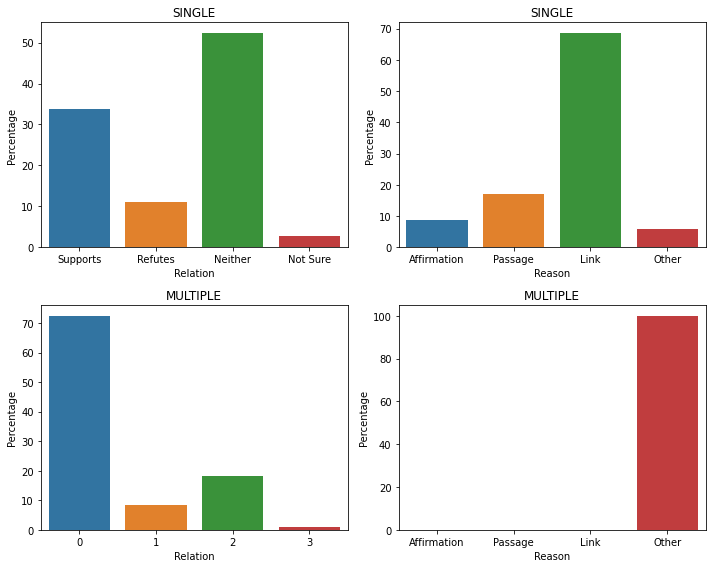

In [17]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

g = sns.barplot(
    data=pilot_results_single_df['relation']
        .value_counts(normalize=True)
        .mul(100)
        .reset_index(),
    x='index',
    y='relation',
    ax=ax[0][0]
)
g.set_xticklabels(RELATION_LABELS)
g.set_title('SINGLE')
g.set_xlabel('Relation')
g.set_ylabel('Percentage')

g = sns.barplot(
    data=pilot_results_single_df[
            pilot_results_single_df['reason_not_sure'] != -1
        ]['reason_not_sure']
        .value_counts(normalize=True).mul(100).reset_index(),
    x='index',
    y='reason_not_sure',
    ax=ax[0][1]
)
g.set_xticklabels(NOT_SURE_LABELS)
g.set_title('SINGLE')
g.set_xlabel('Reason')
g.set_ylabel('Percentage')

g = sns.barplot(
    data=pilot_results_multiple_df['relation']
        .value_counts(normalize=True)
        .mul(100)
        .reset_index(),
    x='index',
    y='relation',
    ax=ax[1][0]
)
#g.set_xticklabels(RELATION_LABELS)
g.set_title('MULTIPLE')
g.set_xlabel('Relation')
g.set_ylabel('Percentage')

g = sns.barplot(
    data=pd.merge(
            pd.DataFrame([0,1,2,3], columns=['index']),
            pilot_results_multiple_df[pilot_results_multiple_df['reason_not_sure'] != -1]['reason_not_sure']
                .value_counts(normalize=True).mul(100).reset_index(),
            how='outer'
        ).fillna(0),
    x='index',
    y='reason_not_sure',
    ax=ax[1][1]
)
g.set_xticklabels(NOT_SURE_LABELS)
g.set_title('MULTIPLE')
g.set_xlabel('Reason')
g.set_ylabel('Percentage')

plt.tight_layout()

### Distribution by worker

In [18]:
print('-'*10,'single','-'*10)
print(f'{pilot_results_single_df.worker_id.unique().shape[0]} unique workers')
print(f'{pilot_results_single_df.shape[0]//6} unique assignments')
print(f'{pilot_results_single_df.shape[0]//6/pilot_results_single_df.worker_id.unique().shape[0]} assignments/worker')

print('-'*10,'multiple','-'*10)
print(f'{pilot_results_multiple_df.worker_id.unique().shape[0]} unique workers')
print(f'{pilot_results_multiple_df.shape[0]//6} unique assignments')
print(f'{pilot_results_multiple_df.shape[0]//6/pilot_results_multiple_df.worker_id.unique().shape[0]} assignments/worker')

---------- single ----------
56 unique workers
115 unique assignments
2.0535714285714284 assignments/worker
---------- multiple ----------
19 unique workers
20 unique assignments
1.0526315789473684 assignments/worker


Text(0.5, 1.0, 'MULTIPLE')

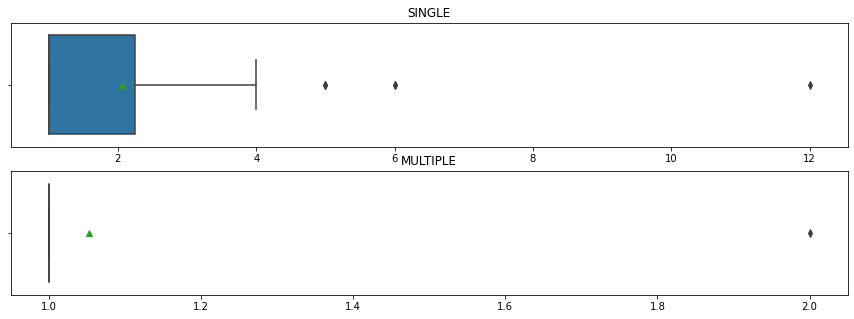

In [19]:
fig, ax = plt.subplots(2,1,figsize=(15,5))

g = sns.boxplot(
    x=pilot_results_single_df.groupby('worker_id').size()//6,
    orient='h',
    ax=ax[0],
    showmeans=True
)# Half of the people did only 1, and some people did more. A person did 12 out of the 23.
g.set_title('SINGLE')

g = sns.boxplot(
    x=pilot_results_multiple_df.groupby('worker_id').size()//6,
    orient='h',
    ax=ax[1],
    showmeans=True
) #Everyone did 1 task except a person who did 2
g.set_title('MULTIPLE')

In [20]:
worker_response_breakdown_relation_single =\
    pilot_results_single_df.groupby('worker_id')['relation'].apply(list).reset_index()

for i in range(0,4):
    worker_response_breakdown_relation_single[f'{RELATION_LABELS[i]}'] = worker_response_breakdown_relation_single['relation'].map(
        lambda x : sum([xx == i for xx in x])/len(x)
    )

worker_response_breakdown_relation_single.drop('relation', axis=1, inplace=True)

worker_response_breakdown_relation_multiple =\
    pilot_results_multiple_df.groupby('worker_id')['relation'].apply(list).reset_index()

for i in range(0,4):
    worker_response_breakdown_relation_multiple[f'{RELATION_LABELS[i]}'] = worker_response_breakdown_relation_multiple['relation'].map(
        lambda x : sum([xx == i for xx in x])/len(x)
    )

worker_response_breakdown_relation_multiple.drop('relation', axis=1, inplace=True)

<AxesSubplot:>

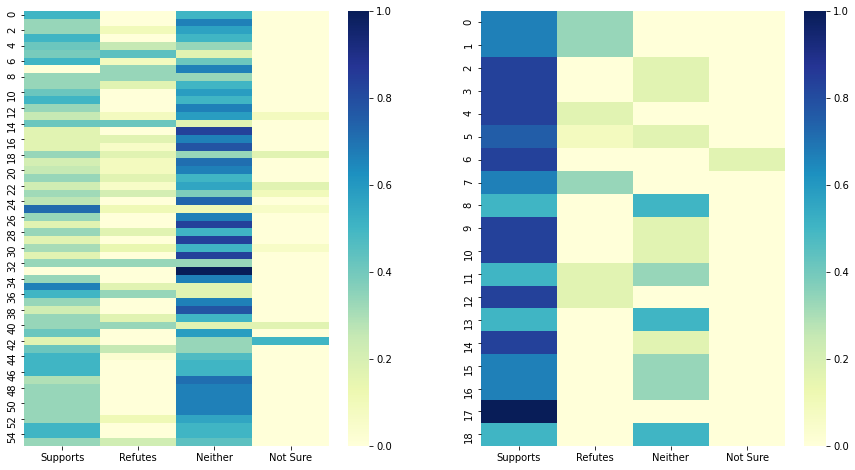

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.heatmap(
    worker_response_breakdown_relation_single.iloc[:,1:],
    ax=ax[0],
    vmin=0, vmax=1, cmap="YlGnBu"
)

sns.heatmap(
    worker_response_breakdown_relation_multiple.iloc[:,1:],
    ax=ax[1],
    vmin=0, vmax=1, cmap="YlGnBu"
)

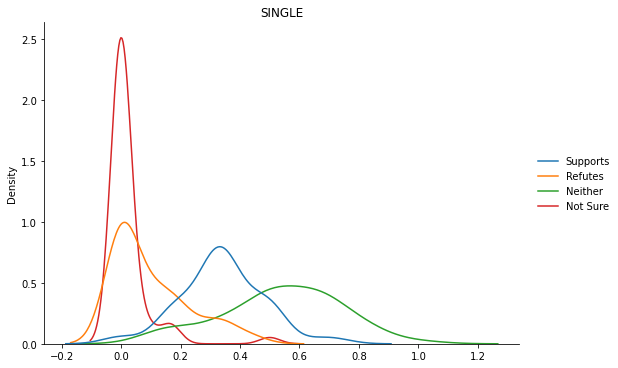

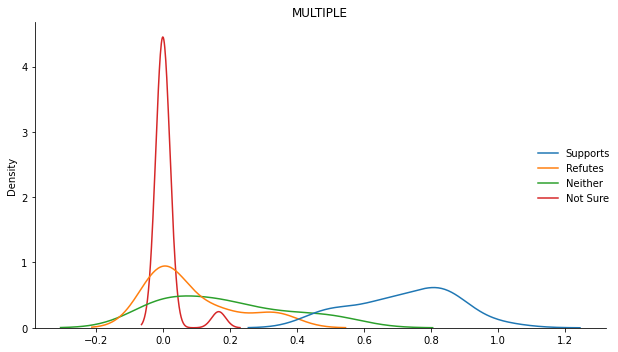

In [22]:
g=sns.displot(worker_response_breakdown_relation_single, kind='kde', height=5, aspect=1.5)
g.set(title='SINGLE')

g=sns.displot(worker_response_breakdown_relation_multiple, kind='kde', height=5, aspect=1.5)
g.set(title='MULTIPLE')
plt.tight_layout()

### Distribution by reference

In [23]:
reference_response_breakdown_relation_single =\
    pilot_results_single_df.groupby(['reference_id','evidence_id'])['relation'].apply(list).reset_index()

for i in range(0,4):
    reference_response_breakdown_relation_single[f'{RELATION_LABELS[i]}'] =\
        reference_response_breakdown_relation_single['relation'].map(
            lambda x : sum([xx == i for xx in x])/len(x)
        )

reference_response_breakdown_relation_single.drop(['evidence_id','relation'], axis=1, inplace=True)

reference_response_breakdown_relation_multiple =\
    pilot_results_multiple_df.groupby('reference_id')['relation'].apply(list).reset_index()

for i in range(0,4):
    reference_response_breakdown_relation_multiple[f'{RELATION_LABELS[i]}'] =\
        reference_response_breakdown_relation_multiple['relation'].map(
            lambda x : sum([xx == i for xx in x])/len(x)
        )

reference_response_breakdown_relation_multiple.drop('relation', axis=1, inplace=True)

<AxesSubplot:>

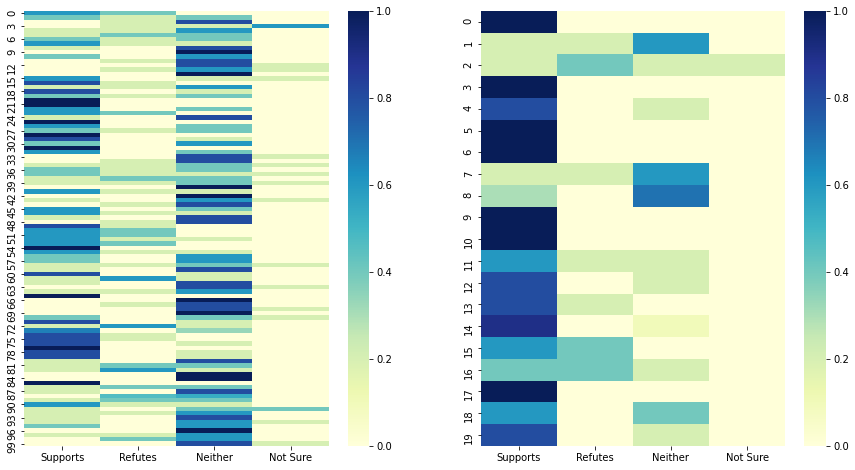

In [24]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.heatmap(
    reference_response_breakdown_relation_single.iloc[:,1:],
    ax=ax[0],
    vmin=0, vmax=1, cmap="YlGnBu"
)

sns.heatmap(
    reference_response_breakdown_relation_multiple.iloc[:,1:],
    ax=ax[1],
    vmin=0, vmax=1, cmap="YlGnBu"
)

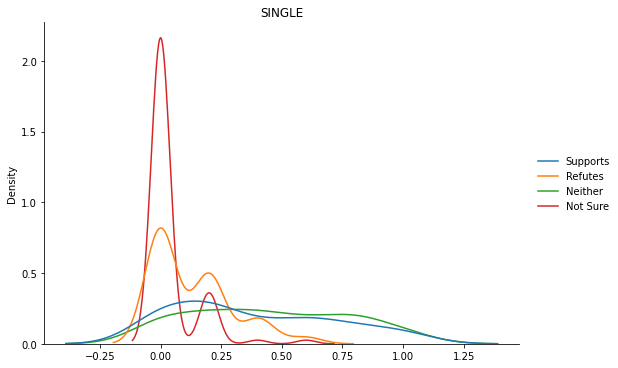

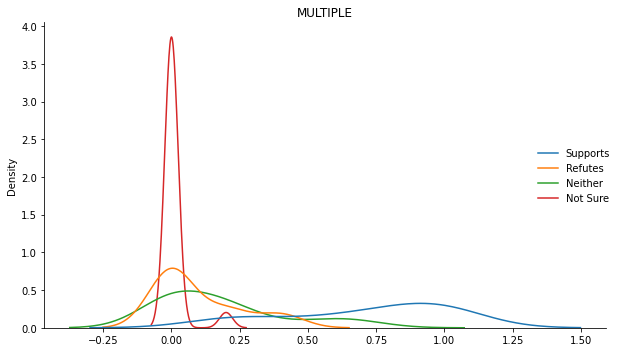

In [25]:
g=sns.displot(reference_response_breakdown_relation_single, kind='kde', height=5, aspect=1.5)
g.set(title='SINGLE')

g=sns.displot(reference_response_breakdown_relation_multiple, kind='kde', height=5, aspect=1.5)
g.set(title='MULTIPLE')
plt.tight_layout()

### Check non-aggregated scores correlation per evidence/reference

In [145]:
# Get scored datasets (filtered for crowdsourcing from GenerateTaskSets)
te_df = pd.read_json('../data/textual_entailment_df_filtered_for_crowdsourcing.json')
# This dataset has scores for references and scores for individual evidence too
# it also has labels for references and labels for individual evidence
te_df.head()

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores,nlp_sentences_all_TOP_N,evidence_TE_prob_all_TOP_N,evidence_TE_prob_weighted_all_TOP_N,evidence_TE_labels_all_TOP_N,claim_TE_prob_weighted_sum_all_TOP_N,claim_TE_label_weighted_sum_all_TOP_N,claim_TE_label_malon_all_TOP_N
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191, -0.9998914599000001, -0.999842...","[-0.9975231290000001, -0.9998638630000001, -0....",[{'sentence': 'He died in an air crash near Ku...,"[[0.9708649516000001, 0.0061447304, 0.02299031...","[[0.9707732797, 0.0061441502, 0.0229881462], [...","[SUPPORTS, SUPPORTS, NOT ENOUGH INFO, NOT ENOU...","[1.9523134232000001, 0.0484717116, 2.5008661747]",NOT ENOUGH INFO,SUPPORTS
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477, -0.9997430444000001, -0.999761...","[-0.9976871014, -0.9997031689, -0.999774158, -...","[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M...","[[0.09385417400000001, 0.2980020344, 0.6081437...","[[0.0830457285, 0.2636834979, 0.5381085873], [...","[NOT ENOUGH INFO, NOT ENOUGH INFO, NOT ENOUGH ...","[0.1000050157, 0.4289829731, 0.8527254462]",NOT ENOUGH INFO,SUPPORTS
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835000001, -0.9997751117, -0.999563...","[-0.9655147195, -0.9992546439000001, -0.999627...",[{'sentence': 'AWB was formed in early 1972 in...,"[[0.9388607144000001, 0.0051775482, 0.05596167...","[[0.9337435365000001, 0.0051493281, 0.05565666...","[SUPPORTS, REFUTES, NOT ENOUGH INFO, NOT ENOUG...","[0.964186728, 0.8969765306, 0.25956323740000004]",SUPPORTS,SUPPORTS
3,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268448000001, -0.9997874498, -0.999821...","[-0.9918303490000001, -0.9996852875000001, -0....","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[[0.7398596406, 0.0883401632, 0.17180021110000...","[[0.7397438288, 0.088326335, 0.1717733145], [0...","[SUPPORTS, NOT ENOUGH INFO, REFUTES, NOT ENOUG...","[0.7442157269, 0.3141435385, 0.5475053787]",SUPPORTS,SUPPORTS
4,1ee71b39caf6df395c64b436fea4895692812d38,Q5289513$B0532490-8FEC-4744-9D74-61238B633898,Dolores Delirio started work in 1994.,24749.538462,https://en.wikipedia.org/w/index.php?title=Dol...,en.wikipedia.org,"[Dolores Delirio., From Wikipedia, the free en...","[Dolores Delirio. From Wikipedia, the free enc...","[-0.49935883280000004, -0.9997779727, -0.99969...","[-0.9781491756, -0.9995777011, -0.9996224642, ...",[{'sentence': 'Dolores Delirio is a Peruvian r...,"[[0.7100448608000001, 0.0457550883, 0.24419999...","[[0.7099757195, 0.0457506366, 0.24417622390000...","[SUPPORTS, NOT ENOUGH INFO, NOT ENOUGH INFO, N...","[0.7102969885, 0.0495032594, 0.2685163021]",SUPPORTS,SUPPORTS


#### Single evidence, sentence retrieval relevance scores

In [146]:
# The pilot_results_single_df dataframe already has evidence-level scores, so we wont need to join from te_df
# we will need to join later for evidence-level textual entailment classification
pilot_results_single_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   claim_id               690 non-null    object 
 1   affirmation            690 non-null    object 
 2   reference_id           690 non-null    object 
 3   reference_url          690 non-null    object 
 4   evidence_id            690 non-null    int64  
 5   sentence_id            690 non-null    object 
 6   evidence               690 non-null    object 
 7   score                  690 non-null    float64
 8   worker_id              690 non-null    object 
 9   assignment_id          690 non-null    object 
 10  relation               690 non-null    int64  
 11  reason_not_sure        690 non-null    int64  
 12  reason_not_sure_other  690 non-null    object 
 13  times                  690 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 75.6+ KB


In [78]:
# Check evidence score against annotations from the "single" task 
pilot_results_single_df_scores = pilot_results_single_df[['reference_id', 'evidence_id', 'score', 'relation']].copy()

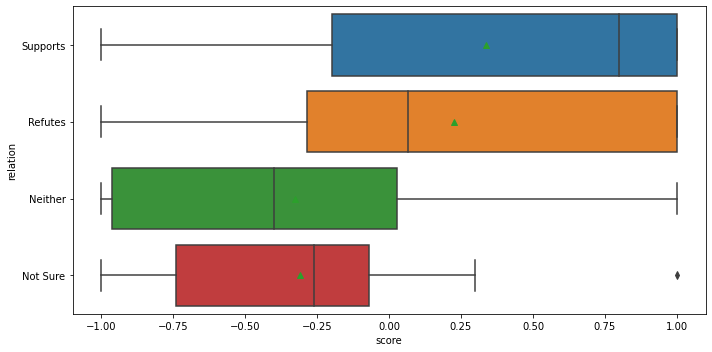

In [79]:
# Investigating sentence retrieval scores
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = pilot_results_single_df_scores,
    x = 'score',
    orient='h',
    y = 'relation', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(RELATION_LABELS)
plt.tight_layout()

In [93]:
pilot_results_single_df_scores.loc[:, 'relevant'] = pilot_results_single_df_scores['relation'].map(
    lambda x : 1 if x in [0,1] else (0 if x == 2 else -1)
)
pilot_results_single_df_scores[pilot_results_single_df_scores['relevant'] >= 0].corr()
#SCORE vs RELEVANT has a 0.426936 correlation

,evidence_id,score,relation,relevant
evidence_id,1.000000,-0.377423,0.273991,-0.248448
score,-0.377423,1.000000,-0.418942,0.426936
relation,0.273991,-0.418942,1.000000,-0.947835
relevant,-0.248448,0.426936,-0.947835,1.000000


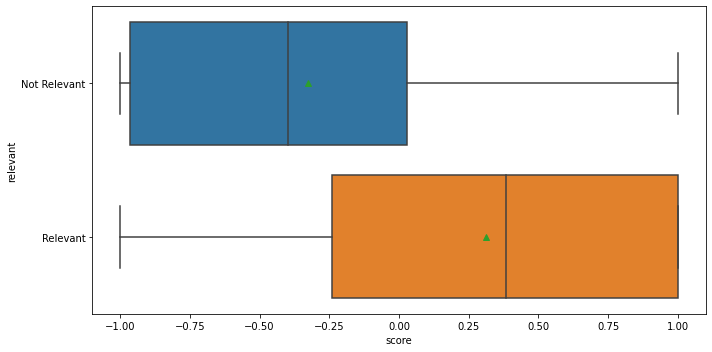

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = pilot_results_single_df_scores[pilot_results_single_df_scores['relevant'] >= 0],
    x = 'score',
    orient='h',
    y = 'relevant', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(['Not Relevant', 'Relevant'])
plt.tight_layout()

#### Single evidence, textual entailment classifications

In [299]:
te_df_evidence_te_model_label = te_df[
    ['reference_id', 'evidence_TE_labels_all_TOP_N','evidence_TE_prob_all_TOP_N']
]
te_df_evidence_te_model_label = te_df_evidence_te_model_label.explode(
    ['evidence_TE_labels_all_TOP_N','evidence_TE_prob_all_TOP_N']
)
te_df_evidence_te_model_label['evidence_id'] = te_df_evidence_te_model_label.groupby('reference_id').cumcount()
te_df_evidence_te_model_label = te_df_evidence_te_model_label[
    ['reference_id', 'evidence_id', 'evidence_TE_labels_all_TOP_N', 'evidence_TE_prob_all_TOP_N']
].reset_index(drop=True)
te_df_evidence_te_model_label.rename({'evidence_TE_labels_all_TOP_N': 'TE_model_label'}, axis=1, inplace=True)
te_df_evidence_te_model_label[
    ['Supports_prob', 'Refutes_prob', 'Neither_prob']
] = pd.DataFrame(te_df_evidence_te_model_label['evidence_TE_prob_all_TOP_N'].to_list())
te_df_evidence_te_model_label.drop('evidence_TE_prob_all_TOP_N',axis=1,inplace=True)

te_labels = {'SUPPORTS':0, 'REFUTES':1, 'NOT ENOUGH INFO':2}

te_df_evidence_te_model_label['TE_model_label_num'] = te_df_evidence_te_model_label['TE_model_label'].map(te_labels)
te_df_evidence_te_model_label

,reference_id,evidence_id,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,0,SUPPORTS,0.970865,0.006145,0.022990,0
1,390d6c6e68a32e11f8d7b0883cda0557db529fe6,1,SUPPORTS,0.916387,0.004485,0.079128,0
2,390d6c6e68a32e11f8d7b0883cda0557db529fe6,2,NOT ENOUGH INFO,0.060523,0.021895,0.917582,2
3,390d6c6e68a32e11f8d7b0883cda0557db529fe6,3,NOT ENOUGH INFO,0.003394,0.008664,0.987942,2
4,390d6c6e68a32e11f8d7b0883cda0557db529fe6,4,NOT ENOUGH INFO,0.004058,0.013481,0.982461,2
...,...,...,...,...,...,...,...
2040,6e6204011de4f4176362a6f4067486a94fc6ac3e,0,NOT ENOUGH INFO,0.101774,0.009051,0.889175,2
2041,6e6204011de4f4176362a6f4067486a94fc6ac3e,1,NOT ENOUGH INFO,0.031923,0.008071,0.960006,2
2042,6e6204011de4f4176362a6f4067486a94fc6ac3e,2,NOT ENOUGH INFO,0.026303,0.006921,0.966776,2
2043,6e6204011de4f4176362a6f4067486a94fc6ac3e,3,NOT ENOUGH INFO,0.025316,0.008242,0.966442,2


In [611]:
pilot_results_single_df_te_labels = pilot_results_single_df[['reference_id', 'evidence_id', 'relation','score']]
pilot_results_single_df_te_labels = pd.merge(
    pilot_results_single_df_te_labels,
    te_df_evidence_te_model_label,
    on=['reference_id', 'evidence_id'],
    how='left'
)
pilot_results_single_df_te_labels

,reference_id,evidence_id,relation,score,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,62eec2975ba36bcf75d8b1f7f69fdac1b5ae2223,0,0,0.999851,SUPPORTS,0.986655,0.002567,0.010778,0
1,e702edc73a8a2da974fb2066c3dc4091b85fe376,1,0,0.065445,SUPPORTS,0.920103,0.060969,0.018928,0
2,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,4,2,-0.398953,NOT ENOUGH INFO,0.017077,0.029690,0.953233,2
3,f36a394c86bc81d2f5c63b0130b0bfa1ffda4cc4,1,2,0.999877,REFUTES,0.114916,0.491628,0.393456,1
4,9339e5a48829f2c6042324052b9cb06b61649453,2,0,0.999032,SUPPORTS,0.970508,0.006966,0.022526,0
...,...,...,...,...,...,...,...,...,...
685,3d830420ab7694849eed20a4307cf44e9ee447be,2,2,-0.333836,NOT ENOUGH INFO,0.024802,0.009825,0.965373,2
686,bb4f43816d7c8fb0ff0e5f22483b22bf86641949,1,2,0.165659,REFUTES,0.035848,0.946761,0.017390,1
687,86139c09cf3d574066e487c92aefa89e37f4f809,4,0,-0.241098,REFUTES,0.074199,0.908088,0.017713,1
688,86139c09cf3d574066e487c92aefa89e37f4f809,3,2,-0.057307,REFUTES,0.035522,0.870521,0.093957,1


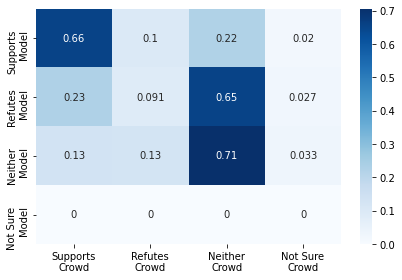

In [612]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_true = pilot_results_single_df_te_labels['TE_model_label_num'],
    y_pred = pilot_results_single_df_te_labels['relation'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True)
g.set_yticklabels([x+'\nModel' for x in RELATION_LABELS])
g.set_xticklabels([x+'\nCrowd' for x in RELATION_LABELS])
plt.tight_layout()

In [613]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_true = pilot_results_single_df_te_labels['TE_model_label_num'],
    y_pred = pilot_results_single_df_te_labels['relation']
)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       250
           1       0.13      0.09      0.11       110
           2       0.65      0.71      0.67       330
           3       0.00      0.00      0.00         0

    accuracy                           0.59       690
   macro avg       0.37      0.36      0.37       690
weighted avg       0.58      0.59      0.59       690



C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [614]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_true = pilot_results_single_df_te_labels['TE_model_label_num'],
    y_pred = pilot_results_single_df_te_labels['relation']
)

cm = pd.DataFrame(cm)
cm.index = [x+' Model' for x in RELATION_LABELS]
cm.columns = [x+' Crowd' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Crowd,Refutes Crowd,Neither Crowd,Not Sure Crowd,Total
Supports Model,164,25,56,5,250
Refutes Model,25,10,72,3,110
Neither Model,44,42,233,11,330
Not Sure Model,0,0,0,0,0
Total,233,77,361,19,690


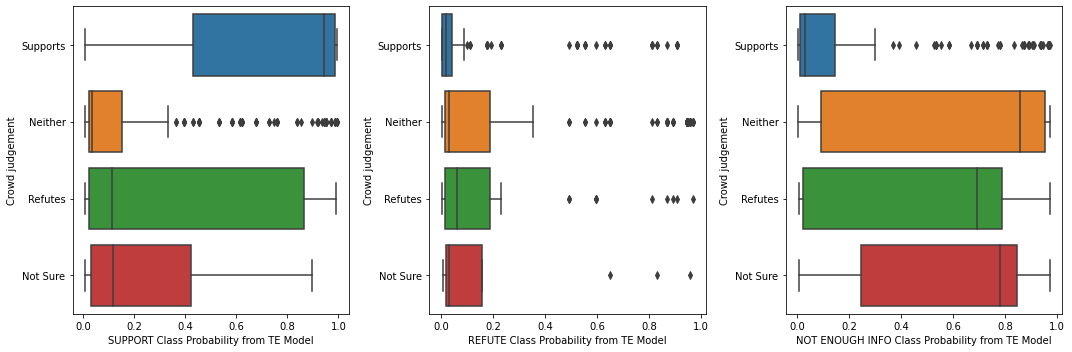

In [615]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

pilot_results_single_df_te_labels['relation_label'] = pilot_results_single_df_te_labels['relation']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=pilot_results_single_df_te_labels,
    x='Supports_prob',
    y='relation_label',
    ax=ax[0]
)
g.set(xlabel='SUPPORT Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_te_labels,
    x='Refutes_prob',
    y='relation_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_te_labels,
    x='Neither_prob',
    y='relation_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model',ylabel='Crowd judgement')

plt.tight_layout()

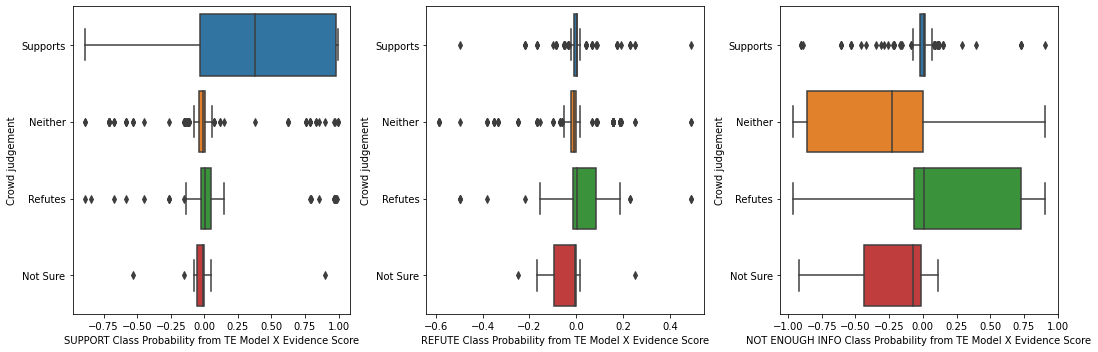

In [616]:
# Lastly, get the same as above but multiplying by scores
for r in ['Supports','Refutes','Neither']:
    pilot_results_single_df_te_labels[f'{r}_prob_times_ev_score'] =\
        pilot_results_single_df_te_labels[f'{r}_prob'] * pilot_results_single_df_te_labels['score']
pilot_results_single_df_te_labels

fig, ax = plt.subplots(1,3,figsize=(15,5))

pilot_results_single_df_te_labels['relation_label'] = pilot_results_single_df_te_labels['relation']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=pilot_results_single_df_te_labels,
    x='Supports_prob_times_ev_score',
    y='relation_label',
    ax=ax[0], 
)
g.set(xlabel='SUPPORT Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_te_labels,
    x='Refutes_prob_times_ev_score',
    y='relation_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_te_labels,
    x='Neither_prob_times_ev_score',
    y='relation_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

plt.tight_layout()

#These charts are the probabilities multiplied by evidence score
# This is to see if, after accounting for relevance, we have:

# In the first chart (Support prob * relevance), a higher amount near the positive values for those voted "Supports"
# by the crowd. WE DO.

# In the second chart (Refute prob * relevance), a higher amount near the positive values for those voted "Refutes"
# by the crowd. WE DO, BUT BARELY, STILL SIMILAR TO NEITHER (although better than not multiplying by relevance)

# Third chart is very promissing, as it shows that there is a CLEAR difference between what the crowd has
# tagged as Neither and what the crowd as tagged as Refutes when one factors in the EVIDENCE SCORES
# on top of the TE class probabilities. This is promising in the case we want to use a final model predictor based
# on the collection of EV scores and TE probabilities for a given reference

#### Multiple evidence, aggregated textual entailment classifications

In [430]:
pilot_results_multiple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   claim_id               120 non-null    object
 1   affirmation            120 non-null    object
 2   reference_id           120 non-null    object
 3   reference_url          120 non-null    object
 4   evidence_list          120 non-null    object
 5   worker_id              120 non-null    object
 6   assignment_id          120 non-null    object
 7   relation               120 non-null    int64 
 8   reason_not_sure        120 non-null    int64 
 9   reason_not_sure_other  120 non-null    object
 10  times                  120 non-null    int64 
dtypes: int64(3), object(8)
memory usage: 10.4+ KB


In [702]:
te_labels = {'SUPPORTS':0, 'REFUTES':1, 'NOT ENOUGH INFO':2}
te_df_pre_join = te_df[
    ['reference_id','claim_id','claim_TE_prob_weighted_sum_all_TOP_N',
     'claim_TE_label_weighted_sum_all_TOP_N', 'claim_TE_label_malon_all_TOP_N']
].copy()
te_df_pre_join = te_df_pre_join.rename({
    'claim_TE_prob_weighted_sum_all_TOP_N': 'WS_TE_probs',
    'claim_TE_label_weighted_sum_all_TOP_N': 'WS_TE_label',
    'claim_TE_label_malon_all_TOP_N': 'MALON_TE_label'    
}, axis = 1)
te_df_pre_join['WS_TE_id'] = te_df_pre_join['WS_TE_label'].map(te_labels)
te_df_pre_join['MALON_TE_id'] = te_df_pre_join['MALON_TE_label'].map(te_labels)
te_df_pre_join

,reference_id,claim_id,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,"[1.9523134232000001, 0.0484717116, 2.5008661747]",NOT ENOUGH INFO,SUPPORTS,2,0
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,"[0.1000050157, 0.4289829731, 0.8527254462]",NOT ENOUGH INFO,SUPPORTS,2,0
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,"[0.964186728, 0.8969765306, 0.25956323740000004]",SUPPORTS,SUPPORTS,0,0
3,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,"[0.7442157269, 0.3141435385, 0.5475053787]",SUPPORTS,SUPPORTS,0,0
4,1ee71b39caf6df395c64b436fea4895692812d38,Q5289513$B0532490-8FEC-4744-9D74-61238B633898,"[0.7102969885, 0.0495032594, 0.2685163021]",SUPPORTS,SUPPORTS,0,0
...,...,...,...,...,...,...,...
404,e004706cba4821386dc31a86faeb680e8fff4ae7,Q58480207$B8B66EE1-CD20-4426-846C-4B37DC5A55A4,"[0, 0, 0]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
405,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,"[0.0111095207, 0.0077722026, 0.1802416742]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
406,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,"[0.0642338172, 0.0029714017, 0.1621499956]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
407,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,"[0.1575524956, 0.0082641244, 0.7491290569]",NOT ENOUGH INFO,SUPPORTS,2,0


In [693]:
pilot_results_multiple_df_scores = pd.merge(
    pilot_results_multiple_df,
    te_df_pre_join,
    on=['reference_id', 'claim_id'],
    how='left'
)[['reference_id', 'relation', 'WS_TE_probs', 'WS_TE_label', 'MALON_TE_label', 'WS_TE_id', 'MALON_TE_id']]

In [694]:
pilot_results_multiple_df_scores.head()

,reference_id,relation,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,c142c251fcb563f07dabef11a283b4fd171f1eb6,0,"[0.0355789587, 0.2486822307, 0.014696830000000...",REFUTES,REFUTES,1,1
1,3d830420ab7694849eed20a4307cf44e9ee447be,3,"[0.0028231924, 0.0004741912, 0.0269695055]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
2,62eec2975ba36bcf75d8b1f7f69fdac1b5ae2223,0,"[3.3224551678, 0.0068372251, 0.030721357100000...",SUPPORTS,SUPPORTS,0,0
3,86139c09cf3d574066e487c92aefa89e37f4f809,0,"[0.0077160583, 0.009958720800000001, 0.0002580...",REFUTES,REFUTES,1,1
4,5e9bc44ce8b4ae04f57985660ab5f880cee53315,0,"[3.5474262238, 0.0363196209, 0.5078652501]",SUPPORTS,SUPPORTS,0,0


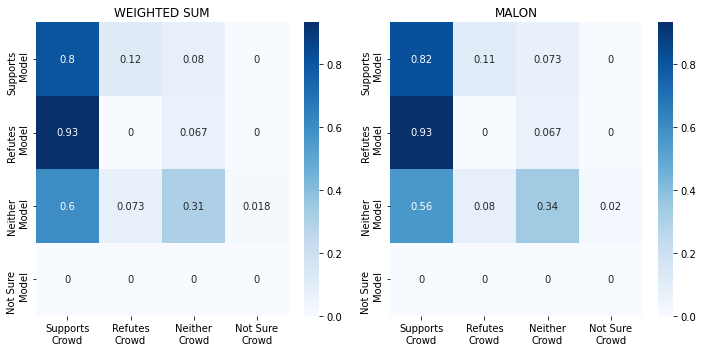

In [695]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(10,5))
cm = confusion_matrix(
    y_true = pilot_results_multiple_df_scores['WS_TE_id'],
    y_pred = pilot_results_multiple_df_scores['relation'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0])
g.set_title('WEIGHTED SUM')
g.set_yticklabels([x+'\nModel' for x in RELATION_LABELS])
g.set_xticklabels([x+'\nCrowd' for x in RELATION_LABELS])

cm = confusion_matrix(
    y_true = pilot_results_multiple_df_scores['MALON_TE_id'],
    y_pred = pilot_results_multiple_df_scores['relation'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1])
g.set_title('MALON')
g.set_yticklabels([x+'\nModel' for x in RELATION_LABELS])
g.set_xticklabels([x+'\nCrowd' for x in RELATION_LABELS])

plt.tight_layout()

In [696]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_true = pilot_results_multiple_df_scores['WS_TE_id'],
    y_pred = pilot_results_multiple_df_scores['relation']
)
print(cr)

cr = classification_report(
    y_true = pilot_results_multiple_df_scores['MALON_TE_id'],
    y_pred = pilot_results_multiple_df_scores['relation']
)
print(cr)

              precision    recall  f1-score   support

           0       0.46      0.80      0.58        50
           1       0.00      0.00      0.00        15
           2       0.77      0.31      0.44        55
           3       0.00      0.00      0.00         0

    accuracy                           0.48       120
   macro avg       0.31      0.28      0.26       120
weighted avg       0.55      0.47      0.45       120

              precision    recall  f1-score   support

           0       0.52      0.82      0.63        55
           1       0.00      0.00      0.00        15
           2       0.77      0.34      0.47        50
           3       0.00      0.00      0.00         0

    accuracy                           0.52       120
   macro avg       0.32      0.29      0.28       120
weighted avg       0.56      0.52      0.49       120



C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [697]:
cm = confusion_matrix(
    y_true = pilot_results_multiple_df_scores['WS_TE_id'],
    y_pred = pilot_results_multiple_df_scores['relation']
)

cm = pd.DataFrame(cm)
cm.index = [x+' Model' for x in RELATION_LABELS]
cm.columns = [x+' Crowd' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Crowd,Refutes Crowd,Neither Crowd,Not Sure Crowd,Total
Supports Model,40,6,4,0,50
Refutes Model,14,0,1,0,15
Neither Model,33,4,17,1,55
Not Sure Model,0,0,0,0,0
Total,87,10,22,1,120


In [698]:
cm = confusion_matrix(
    y_true = pilot_results_multiple_df_scores['MALON_TE_id'],
    y_pred = pilot_results_multiple_df_scores['relation']
)

cm = pd.DataFrame(cm)
cm.index = [x+' Model' for x in RELATION_LABELS]
cm.columns = [x+' Crowd' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Crowd,Refutes Crowd,Neither Crowd,Not Sure Crowd,Total
Supports Model,45,6,4,0,55
Refutes Model,14,0,1,0,15
Neither Model,28,4,17,1,50
Not Sure Model,0,0,0,0,0
Total,87,10,22,1,120


### Agreement

In [494]:
def prep_for_kripp(df, id_col, resp_col, fun=np.median, fillna = None):
    '''
    WE TAKE THE MIN HERE, UNDER THE PREMISE THAT IF A WORKER SAW THE SAME SENTENCE TWICE AND GAVE IT TWO SCORES,
    THE LESSER SCORE WOULD REFLECT DIFFICULTIES THE WORKER HAD THAT MIGHT NOT HAVE BEEN ON THEIR MIND DURING THE
    GREATER SCORE ASSIGNMENT, BUT THAT ARE REAL NONETHELESS AND MUST BE REPORTED
    '''
    df = df.copy()
    df = df[['worker_id',id_col, resp_col]]\
        .groupby(['worker_id',id_col]).agg(fun).reset_index()
    df = df.pivot(index='worker_id',columns=id_col,values=resp_col)
    if fillna:
        df = df.fillna('*')
    return df

def prep_for_fleiss(df, id_col, resp_col):
    df = df.copy()    
    df = df[[id_col,resp_col]]
    df['count'] = 1
    df = df.groupby([id_col,resp_col]).sum().reset_index()
    df = df.pivot(index=id_col, columns=resp_col, values='count').fillna(0)
    df = df[df.apply(lambda x : sum(x) == 5.0, axis=1)]
    return df

In [485]:
df = pd.DataFrame({
  "a": [5,   5,    5,    5,    5],
  "b": [5,   5,    4,    5,    4],
  "c": ['*', 5,   '*', '*',    5],
  "d": [5,   5,    3,    5,  '*'],
  "e": [5, '*',    5,    4,    5],
  "f": [5,   3,    5,    4,    5],
}).T
ka.krippendorff_alpha(df.values, ka.interval_metric, missing_items='*')

# WHILE DISTRIBUTIONS LIKE THE ONE ABOVE SCORE VERY LOW, FLIPPING 3s AND 5s IN THE SECOND COLUMN, WHICH
# SHOULD NOT CHANGE AGREEMENT, ACTUALLY INCREASES IT A LOT (0.37)
# AND CHANGING IT TO [1,2,3,4,*,5] WHICH SHOULD DECREASE AGREEMENT ACTUALLY INCREASES IT TOO (to 0.34)

# THE ISSUE HERE, AFTER TALKING WITH EDDY, IS THE LACK OF ANNOTATION VARIABILITY. THERE IS NO INDICATION THAT PEOPLE
# CAN RATE ANYTHING OTHER THAN 5,4 AND 3, AND THE SPREAD SEEMS TO FAVOUR 5 SO THAT IT IS EXPECTED THAT THINGS WILL 
# MOSTLY BE A 5

-0.06779661016949157

In [498]:
import krippendorff_alpha as ka 
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss

aggr_levels_relevancy = {}

aggr_levels_relevancy['single'] = {}

pilot_results_single_df['reference_evidence_id'] = pilot_results_single_df.apply(
    lambda row : row['reference_id'] + '$' + str(row['evidence_id']), axis=1
)

pilot_single_df_kripp = prep_for_kripp(
    pilot_results_single_df,
    id_col = 'reference_evidence_id',
    resp_col='relation',
    fillna='*'
)
pilot_single_df_fleiss = prep_for_fleiss(
    pilot_results_single_df,
    id_col = 'reference_evidence_id',
    resp_col='relation'
)

aggr_levels_relevancy['single']['kalpha'] = ka.krippendorff_alpha(
    pilot_single_df_kripp.values, ka.nominal_metric, missing_items='*'
)
aggr_levels_relevancy['single']['fkappa'] = fleiss(pilot_single_df_fleiss)
aggr_levels_relevancy['single']['rkappa'] = fleiss(pilot_single_df_fleiss, method = 'rand')


aggr_levels_relevancy['multiple'] = {}

pilot_multiple_df_kripp = prep_for_kripp(
    pilot_results_multiple_df,
    id_col = 'reference_id',
    resp_col='relation',
    fillna='*'
)
pilot_multiple_df_fleiss = prep_for_fleiss(
    pilot_results_multiple_df,
    id_col = 'reference_id',
    resp_col='relation'
)

aggr_levels_relevancy['multiple']['kalpha'] = ka.krippendorff_alpha(
    pilot_multiple_df_kripp.values, ka.nominal_metric, missing_items='*'
)
aggr_levels_relevancy['multiple']['fkappa'] = fleiss(pilot_multiple_df_fleiss)
aggr_levels_relevancy['multiple']['rkappa'] = fleiss(pilot_multiple_df_fleiss, method = 'rand')

aggr_metrics = pd.DataFrame(aggr_levels_relevancy)
aggr_metrics

,single,multiple
kalpha,0.323056,0.240922
fkappa,0.195247,0.142300
rkappa,0.311594,0.450000


RKappa values place agreement into fair-moderate brackets according to Landis & Koch

![Landis&Koch](https://www.researchgate.net/profile/William-Gallagher-6/publication/7074647/figure/tbl1/AS:669654062202881@1536669378842/Interpretation-of-Landis-and-Koch-kappa-values.png)

### Aggregated results

#### Single evidence

In [515]:
pilot_results_single_df_agg = pilot_results_single_df.copy()
pilot_results_single_df_agg = pilot_results_single_df_agg\
    .groupby(['reference_evidence_id']).agg(list)

for c in pilot_results_single_df_agg.columns:
    if c in ['worker_id','assignment_id','relation','reason_not_sure','reason_not_sure_others','time']:
        continue
    else:
        if pilot_results_single_df_agg[c].map(lambda x : pd.Series(x).unique().size == 1).all():
            pilot_results_single_df_agg[c] = pilot_results_single_df_agg[c]\
                .map(lambda x : pd.Series(x).unique()[0])
            
pilot_results_single_df_agg.head()

,claim_id,affirmation,reference_id,reference_url,evidence_id,sentence_id,evidence,score,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
reference_evidence_id,,,,,,,,,,,,,,
2b3521dca65c1b040551a9e60c3c7e53b2c13929$0,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,Robert Joseph Twyman was in World War I.,2b3521dca65c1b040551a9e60c3c7e53b2c13929,https://bioguide.congress.gov/search/bio/T000444,0,1,House Years of Service 1947 – 1949 State / Ter...,0.999729,"[A1XEO0N2UAO8W3, A2YM0L9BZK5CHW, AKQAI78JTXXC9...","[34X6J5FLPXA3L3SA06ALPU2BX0MJQ1, 3DQQ64TANKX4R...","[1, 1, 0, 0, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[23896, 28276, 16870, 22525, 142560]"
2b3521dca65c1b040551a9e60c3c7e53b2c13929$1,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,Robert Joseph Twyman was in World War I.,2b3521dca65c1b040551a9e60c3c7e53b2c13929,https://bioguide.congress.gov/search/bio/T000444,1,0,"Back Download { JSON } <XML> TWYMAN, Robert Jo...",-0.963734,"[AY7LRW5Q88WL7, AFU00NU09CFXE, A2UTA9FQ8TX5A4,...","[33FBRBDW6SBA7LM84KCZGZ4GDAIC8W, 3XXU1SWE8Q74W...","[1, 0, 2, 2, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[10832, 39291, 27497, 10029, 30993]"
2b3521dca65c1b040551a9e60c3c7e53b2c13929$2,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,Robert Joseph Twyman was in World War I.,2b3521dca65c1b040551a9e60c3c7e53b2c13929,https://bioguide.congress.gov/search/bio/T000444,2,8,Uh oh!,-0.998790,"[A11042NCTA8PGT, AI6U09NVOZ62B, A48WNR6C4CI3J,...","[37ZHEEHM60YIU7L61M9S9W4RWDZ372, 3OXV7EAXLI2ZQ...","[2, 2, 2, 1, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[8174, 10562, 15320, 5348, 6697]"
2b3521dca65c1b040551a9e60c3c7e53b2c13929$3,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,Robert Joseph Twyman was in World War I.,2b3521dca65c1b040551a9e60c3c7e53b2c13929,https://bioguide.congress.gov/search/bio/T000444,3,3;4,The 80th United States Congress Bibliography T...,-0.999479,"[A2ZGZQDUKF2B4G, A3036HFJEJD76X, A3NYY4WL4VLBZ...","[3EICBYG6488ZR2IRVO9Q5PDUTLCCJG, 3GGAI1SQEZAPS...","[2, 3, 3, 3, 1]","[-1, 2, 2, 2, -1]","[, , , , ]","[15031, 16990, 28823, 17933, 15768]"
2b3521dca65c1b040551a9e60c3c7e53b2c13929$4,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,Robert Joseph Twyman was in World War I.,2b3521dca65c1b040551a9e60c3c7e53b2c13929,https://bioguide.congress.gov/search/bio/T000444,4,7,CONTACT Office of the House Historian: history...,-0.999601,"[AY7LRW5Q88WL7, AFU00NU09CFXE, A2UTA9FQ8TX5A4,...","[33FBRBDW6SBA7LM84KCZGZ4GDAIC8W, 3XXU1SWE8Q74W...","[0, 2, 1, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[4584, 23335, 27560, 13635, 11294]"


Possible majority voting layouts:

The table lists the number of votes the #N-st voted choice received.\
E.g. the first row shows the case of an unanimous vote, the third shows a 60/40 split between two choices, etc.

There is a clear winner in cases 1-5:

|Case|\#1|\#2|\#3|\#4|
|----|---|---|---|---|
|*1*   |5  |0  |0  |0  |
|*2*   |4  |1  |0  |0  |
|*3*   |3  |1  |1  |0  |
|*4*   |3  |2  |0  |0  |
|*5*   |2  |1  |1  |1  |
|*6*   |2  |2  |1  |0  |

However in case 6, things get complicated as we have a tie.\
This depends on who is tying with who. Let's propose the following decision table for ties:


| |0|1|2|3|
|-|-|-|-|-|
|0| |2|0|0|
|1| | |1|1|
|2| | | |2|
|3| | | | |

Clarifications:\
0-1: Half of majority says supports, half says refutes, we assume conflicting evidence, take the middle ground and say 2 = Neither.\
0-2: Supporting is a stronger conclusion than neither, which might be due to misinterpretation, vagueness, or different subjective degrees of "enough proof".\
0-3: Any tie with "Not sure" will go to the other class, as "not sure" can not be relied upon.\
1-2: Same as 0-2.\
1-3: Same as 0-3.\
2-3: Same as 0-3.\

In [573]:
# Remember: 0=supports, 1=refutes, 2=neither, 3=notsure
def get_majority_relation(relations):
    relations = pd.Series(relations)
    relations_vc = relations.value_counts()
    
    majority_relation = -1
    tie = False
    
    if relations_vc.iloc[0] >= 3:
        # Cases 1-4
        majority_relation =  relations_vc.index[0]
        
    elif relations_vc.iloc[0] == 2:
        if relations_vc.iloc[1] == 1:
            # Case 5
            majority_relation =  relations_vc.index[0]
        else:
            # Case 6
            tie=True
            assert relations_vc.iloc[1] == 2
            # Implement tie table
            tie_1, tie_2 = relations_vc.index[0], relations_vc.index[1]
            if (tie_1, tie_2) in [(0,1), (1,0), (2,3), (3,2)]:
                majority_relation = 2
            elif (tie_1, tie_2) in [(0,2), (2,0), (0,3), (3,0)]:
                majority_relation = 0          
            elif (tie_1, tie_2) in [(1,2), (2,1), (1,3), (3,1)]:
                majority_relation = 1
            
    return majority_relation, tie

def get_majority_reason_not_sure(reasons):
    reasons = pd.Series(reasons)
    reasons_vc = reasons.value_counts()
    reasons_vc.drop(-1, inplace=True)
    if reasons_vc.size == 0:
        return -1
    return reasons_vc.index[0]

assert get_majority_relation([2,3,3,3,1]) == (3, False)
assert get_majority_relation([1, 1, 0, 0, 0]) == (0, False)
assert get_majority_relation([1, 1, 2, 2, 0]) == (1,True)


assert get_majority_reason_not_sure([-1, -1, -1, -1, -1]) == -1
assert get_majority_reason_not_sure([0, -1, -1, -1, -1]) == 0

In [575]:
relation_majs = pilot_results_single_df_agg['relation'].map(get_majority_relation)
pilot_results_single_df_agg['relation_maj'] = [x[0] for x in relation_majs]
pilot_results_single_df_agg['relation_maj_tie'] = [x[1] for x in relation_majs]
pilot_results_single_df_agg['reason_not_sure_maj'] = pilot_results_single_df_agg['reason_not_sure']\
    .map(get_majority_reason_not_sure)
pilot_results_single_df_agg = pilot_results_single_df_agg[
    ['reference_id','evidence_id','score','relation_maj','relation_maj_tie','reason_not_sure_maj']
].copy()
pilot_results_single_df_agg

,reference_id,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj
reference_evidence_id,,,,,,
2b3521dca65c1b040551a9e60c3c7e53b2c13929$0,2b3521dca65c1b040551a9e60c3c7e53b2c13929,0,0.999729,0,False,-1
2b3521dca65c1b040551a9e60c3c7e53b2c13929$1,2b3521dca65c1b040551a9e60c3c7e53b2c13929,1,-0.963734,0,True,-1
2b3521dca65c1b040551a9e60c3c7e53b2c13929$2,2b3521dca65c1b040551a9e60c3c7e53b2c13929,2,-0.998790,2,False,-1
2b3521dca65c1b040551a9e60c3c7e53b2c13929$3,2b3521dca65c1b040551a9e60c3c7e53b2c13929,3,-0.999479,3,False,2
2b3521dca65c1b040551a9e60c3c7e53b2c13929$4,2b3521dca65c1b040551a9e60c3c7e53b2c13929,4,-0.999601,2,False,-1
...,...,...,...,...,...,...
f5e78b84803a84ce5f6e5f02784dc7dd52d80739$0,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,0,-0.964779,2,False,-1
f5e78b84803a84ce5f6e5f02784dc7dd52d80739$1,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,1,-0.986909,2,False,2
f5e78b84803a84ce5f6e5f02784dc7dd52d80739$2,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,2,-0.994741,2,False,-1


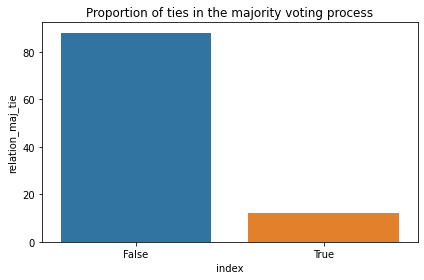

In [589]:
g = sns.barplot(
    data = pilot_results_single_df_agg
    .relation_maj_tie
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(),    
    x='index',
    y='relation_maj_tie',
)
g.set_title('Proportion of ties in the majority voting process')
plt.tight_layout()

#### Single evidence, EV scores

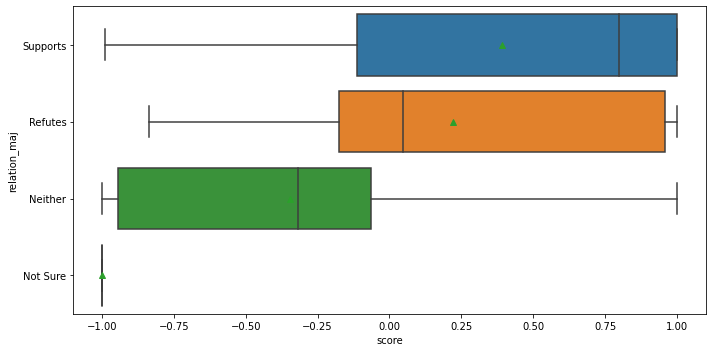

In [591]:
# Investigating sentence retrieval scores
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = pilot_results_single_df_agg,
    x = 'score',
    orient='h',
    y = 'relation_maj', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(RELATION_LABELS)
plt.tight_layout()

In [592]:
pilot_results_single_df_agg.loc[:, 'relevant_maj'] = pilot_results_single_df_agg['relation_maj'].map(
    lambda x : 1 if x in [0,1] else (0 if x == 2 else -1)
)

pilot_results_single_df_agg[pilot_results_single_df_agg['relevant_maj'] >= 0].corr()
#SCORE vs RELEVANT has a 0.504921 correlation

,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj,relevant_maj
evidence_id,1.000000,-0.367180,0.305060,-0.106503,0.105064,-0.306393
score,-0.367180,1.000000,-0.503082,0.028080,-0.145451,0.504921
relation_maj,0.305060,-0.503082,1.000000,-0.173230,0.171764,-0.962049
relation_maj_tie,-0.106503,0.028080,-0.173230,1.000000,-0.026543,0.291107
reason_not_sure_maj,0.105064,-0.145451,0.171764,-0.026543,1.000000,-0.181190
relevant_maj,-0.306393,0.504921,-0.962049,0.291107,-0.181190,1.000000


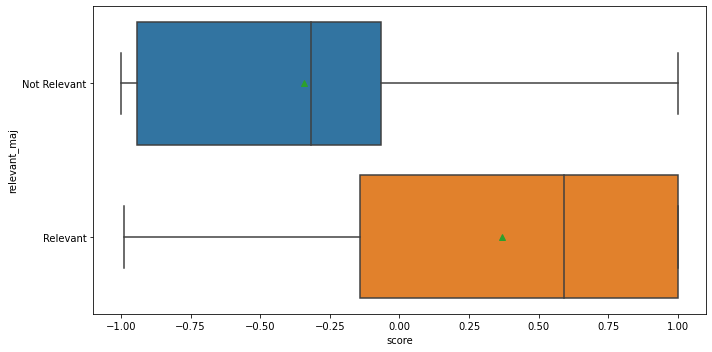

In [593]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = pilot_results_single_df_agg[pilot_results_single_df_agg['relevant_maj'] >= 0],
    x = 'score',
    orient='h',
    y = 'relevant_maj', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(['Not Relevant', 'Relevant'])
plt.tight_layout()

#### Single evidence, TE labels and probs

In [597]:
pilot_results_single_df_agg_te_labels = pd.merge(
    pilot_results_single_df_agg,
    te_df_evidence_te_model_label,
    on=['reference_id', 'evidence_id'],
    how='left'
)
pilot_results_single_df_agg_te_labels

,reference_id,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj,relevant_maj,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,2b3521dca65c1b040551a9e60c3c7e53b2c13929,0,0.999729,0,False,-1,1,NOT ENOUGH INFO,0.037468,0.231006,0.731525,2
1,2b3521dca65c1b040551a9e60c3c7e53b2c13929,1,-0.963734,0,True,-1,1,NOT ENOUGH INFO,0.010405,0.053179,0.936416,2
2,2b3521dca65c1b040551a9e60c3c7e53b2c13929,2,-0.998790,2,False,-1,0,NOT ENOUGH INFO,0.024683,0.062670,0.912647,2
3,2b3521dca65c1b040551a9e60c3c7e53b2c13929,3,-0.999479,3,False,2,-1,NOT ENOUGH INFO,0.008561,0.156292,0.835148,2
4,2b3521dca65c1b040551a9e60c3c7e53b2c13929,4,-0.999601,2,False,-1,0,NOT ENOUGH INFO,0.010120,0.100411,0.889468,2
...,...,...,...,...,...,...,...,...,...,...,...,...
95,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,0,-0.964779,2,False,-1,0,NOT ENOUGH INFO,0.036982,0.022889,0.940129,2
96,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,1,-0.986909,2,False,2,0,NOT ENOUGH INFO,0.022354,0.023227,0.954419,2
97,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,2,-0.994741,2,False,-1,0,SUPPORTS,0.678962,0.032146,0.288892,0
98,f5e78b84803a84ce5f6e5f02784dc7dd52d80739,3,-0.995320,2,False,-1,0,NOT ENOUGH INFO,0.013433,0.017577,0.968989,2


In [600]:
pilot_results_single_df_agg_te_labels.head(10)

,reference_id,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj,relevant_maj,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,2b3521dca65c1b040551a9e60c3c7e53b2c13929,0,0.999729,0,False,-1,1,NOT ENOUGH INFO,0.037468,0.231006,0.731525,2
1,2b3521dca65c1b040551a9e60c3c7e53b2c13929,1,-0.963734,0,True,-1,1,NOT ENOUGH INFO,0.010405,0.053179,0.936416,2
2,2b3521dca65c1b040551a9e60c3c7e53b2c13929,2,-0.998790,2,False,-1,0,NOT ENOUGH INFO,0.024683,0.062670,0.912647,2
3,2b3521dca65c1b040551a9e60c3c7e53b2c13929,3,-0.999479,3,False,2,-1,NOT ENOUGH INFO,0.008561,0.156292,0.835148,2
4,2b3521dca65c1b040551a9e60c3c7e53b2c13929,4,-0.999601,2,False,-1,0,NOT ENOUGH INFO,0.010120,0.100411,0.889468,2
5,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,0,-0.138080,1,True,-1,1,SUPPORTS,0.972349,0.002275,0.025376,0
6,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,1,-0.154805,0,True,-1,1,NOT ENOUGH INFO,0.365209,0.049030,0.585761,2
7,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,2,-0.198882,0,False,0,1,SUPPORTS,0.746708,0.039583,0.213709,0
8,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,3,-0.318156,2,False,-1,0,NOT ENOUGH INFO,0.453176,0.021566,0.525259,2
9,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,4,-0.398953,2,False,-1,0,NOT ENOUGH INFO,0.017077,0.029690,0.953233,2


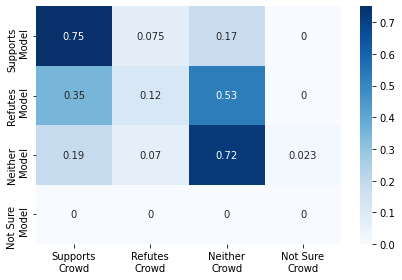

In [599]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_true = pilot_results_single_df_agg_te_labels['TE_model_label_num'],
    y_pred = pilot_results_single_df_agg_te_labels['relation_maj'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True)
g.set_yticklabels([x+'\nModel' for x in RELATION_LABELS])
g.set_xticklabels([x+'\nCrowd' for x in RELATION_LABELS])
plt.tight_layout()

In [601]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_true = pilot_results_single_df_agg_te_labels['TE_model_label_num'],
    y_pred = pilot_results_single_df_agg_te_labels['relation_maj']
)
print(cr)

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        40
           1       0.25      0.12      0.16        17
           2       0.66      0.72      0.69        43
           3       0.00      0.00      0.00         0

    accuracy                           0.63       100
   macro avg       0.40      0.40      0.39       100
weighted avg       0.60      0.63      0.61       100



C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [602]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_true = pilot_results_single_df_agg_te_labels['TE_model_label_num'],
    y_pred = pilot_results_single_df_agg_te_labels['relation_maj']
)

cm = pd.DataFrame(cm)
cm.index = [x+' Model' for x in RELATION_LABELS]
cm.columns = [x+' Crowd' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Crowd,Refutes Crowd,Neither Crowd,Not Sure Crowd,Total
Supports Model,30,3,7,0,40
Refutes Model,6,2,9,0,17
Neither Model,8,3,31,1,43
Not Sure Model,0,0,0,0,0
Total,44,8,47,1,100


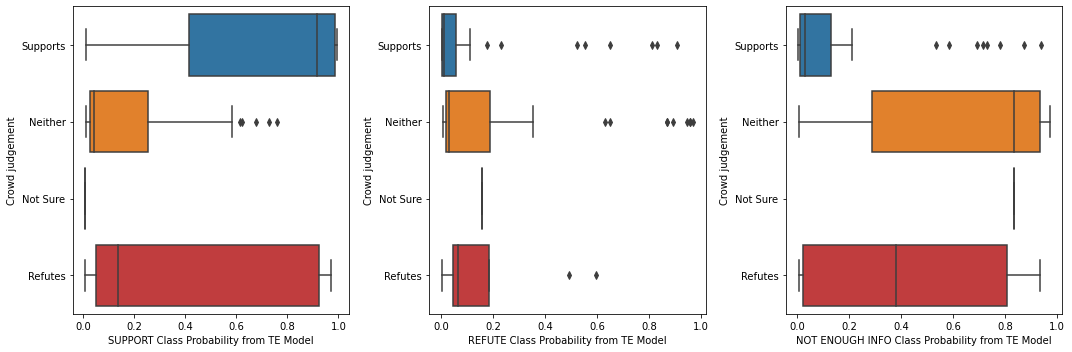

In [607]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

pilot_results_single_df_agg_te_labels['relation_maj_label'] = pilot_results_single_df_agg_te_labels['relation_maj']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=pilot_results_single_df_agg_te_labels,
    x='Supports_prob',
    y='relation_maj_label',
    ax=ax[0]
)
g.set(xlabel='SUPPORT Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_agg_te_labels,
    x='Refutes_prob',
    y='relation_maj_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_agg_te_labels,
    x='Neither_prob',
    y='relation_maj_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model',ylabel='Crowd judgement')

plt.tight_layout()

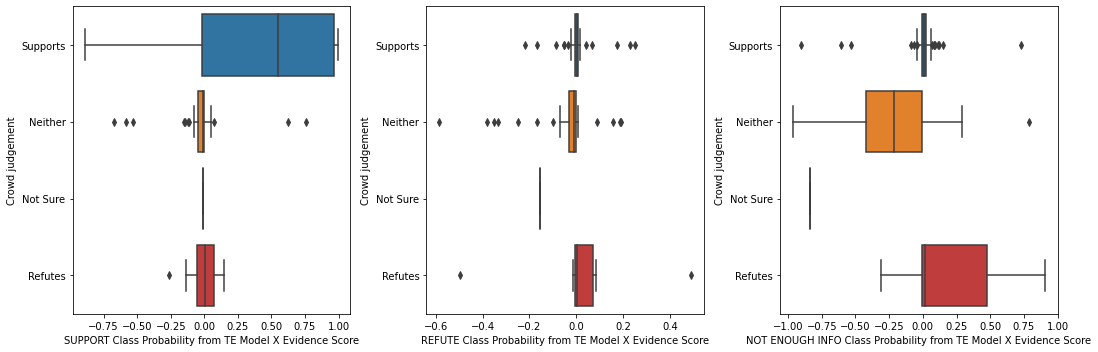

In [608]:
# Lastly, get the same as above but multiplying by scores
for r in ['Supports','Refutes','Neither']:
    pilot_results_single_df_agg_te_labels[f'{r}_prob_times_ev_score'] =\
        pilot_results_single_df_agg_te_labels[f'{r}_prob'] * pilot_results_single_df_agg_te_labels['score']
pilot_results_single_df_te_labels

fig, ax = plt.subplots(1,3,figsize=(15,5))

g = sns.boxplot(
    data=pilot_results_single_df_agg_te_labels,
    x='Supports_prob_times_ev_score',
    y='relation_maj_label',
    ax=ax[0], 
)
g.set(xlabel='SUPPORT Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_agg_te_labels,
    x='Refutes_prob_times_ev_score',
    y='relation_maj_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_single_df_agg_te_labels,
    x='Neither_prob_times_ev_score',
    y='relation_maj_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

plt.tight_layout()

EDIT OF THE COMMENTS ON INDIVIDUAL NON-AGGREGATED RELATION ANNOTATIONS because it still applies.

These charts are the probabilities multiplied by evidence score.\
This is to see if, after accounting for relevance, we have:

In the first chart (Support prob * relevance), a higher amount near the positive values for those voted "Supports" by the crowd. WE DO.

In the second chart (Refute prob * relevance), a higher amount near the positive values for those voted "Refutes" by the crowd. WE DO, BUT BARELY, STILL SIMILAR TO NEITHER (although better than not multiplying by relevance).

Third chart is promissing, as it shows that there is a CLEAR difference between what the crowd has tagged as Neither and what the crowd as tagged as Refutes when one factors in the EVIDENCE SCORES on top of the "Neither" TE class probability. This is promising in the case we want to use a final model predictor basedon the collection of EV scores and TE probabilities for a given reference.

The takeaways HERE are that:
- for evidence judged by the crowd to be SUPPORTIVE, it has positive values of EV_score*Supports_prob and close to 0 values for the other two classes.
- for evidence judged by the crowd to be NEITHER, it has very near 0 EV_score*X_prob for X = Supports and Refutes, and 0 to negative values in the case of X = NEI
- for evidence judged by the crowd to be REFUTING, it has very near 0 EV_score*Supports_prob, slightly positive values of EV_score*Refutes_prob, and values of EV_score*NEI_prob mostly on the positive spectrum

The above observations mean that, given all 3 of an evidence's EV_score\*TE_prob distributions, we might find the most probable class it would be majority voted as.

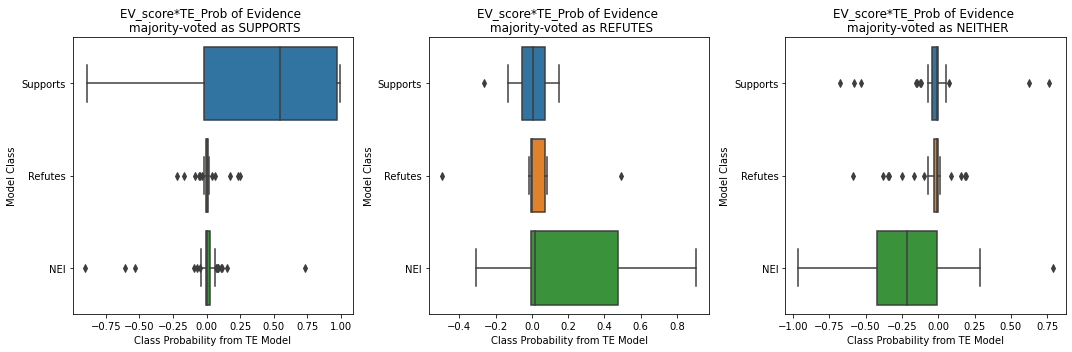

In [715]:
# These plots here are just an inverse of the plots above and illustrate the point written on the previous cell
fig, ax = plt.subplots(1,3,figsize=(15,5))

pilot_results_single_df_agg_te_labels['relation_maj_label'] = pilot_results_single_df_agg_te_labels['relation_maj']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

for i, cl in enumerate(['SUPPORTS','REFUTES','NEITHER']):
    g = sns.boxplot(
        data=pilot_results_single_df_agg_te_labels[
                pilot_results_single_df_agg_te_labels['relation_maj'] == i
            ][['Supports_prob_times_ev_score','Refutes_prob_times_ev_score','Neither_prob_times_ev_score']]
            .melt(),
        y='variable',
        x='value', ax=ax[i]
    )

    g.set(
        xlabel='Class Probability from TE Model',
        ylabel='Model Class',
        yticklabels=['Supports','Refutes','NEI'],
        title=f'EV_score*TE_Prob of Evidence \n majority-voted as {cl}'
    )
    
plt.tight_layout()

# TODO

Repeat the Confusion Matrix but, for all Model class outputs, if the score is under THR (starting at 0), bin it to "Neither Model" instead and see what happens (also check classification scores based on THR).

See also if there is a sizeable difference between supports and refutes probs. If there is not, and evidence-score is not under THR, put it as Refutes. A sizeable difference can be like Sup_prob > Ref_prob + N*|Ref_prob| or Sup_prob > Ref_prob + N*Std(Ref_prob distribution for those majority voted as refutes).

See how varying (THR,N) will affect classification.\
In an essence, would probabily be better to fit some model M such that it uses all three probs and the evidence score.

COME BACK TO THIS WHILE RUNNING CROWDSOURCING MAIN CAMPAIGN

Also see breakdown of correlation between relation/relevant to score (EV) and  TE classification accuracy according to netloc_agg

#### Multiple Evidence

In [679]:
pilot_results_multiple_df_agg = pilot_results_multiple_df.copy()
pilot_results_multiple_df_agg = pilot_results_multiple_df_agg\
    .groupby(['reference_id']).agg(list)
pilot_results_multiple_df_agg.drop(
    ['evidence_list'], axis=1, inplace=True
)

for c in pilot_results_multiple_df_agg.columns:
    if c in ['worker_id','assignment_id','relation','reason_not_sure','reason_not_sure_others','time']:
        continue
    else:
        if pilot_results_multiple_df_agg[c].map(lambda x : pd.Series(x).unique().size == 1).all():
            pilot_results_multiple_df_agg[c] = pilot_results_multiple_df_agg[c]\
                .map(lambda x : pd.Series(x).unique()[0])
            
pilot_results_multiple_df_agg.head()

,claim_id,affirmation,reference_url,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
reference_id,,,,,,,,,
2b3521dca65c1b040551a9e60c3c7e53b2c13929,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,Robert Joseph Twyman was in World War I.,https://bioguide.congress.gov/search/bio/T000444,"[A1VFOKKVJ7B9D6, AM65LGXJBTJ0I, AN4P0SU1YSPF2,...","[36U2A8VAG5B75PPE91RR3V5QBYUKYV, 3X66WABAJ0U1N...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[, , , , , , , , , ]","[89613, 76484, 39037, 476893, 108221, 55536, 6..."
2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,Q27041785$DCF8C3E4-E0A3-4D62-BEF5-5AFED48A168B,MBK Rieker Komárno won the 2016–17 Alpe Adria ...,https://en.wikipedia.org/w/index.php?title=201...,"[A111ZFNLXK1TCO, A3T9WZOUQGE2UW, A2825I2XO6KZE...","[39OWYR0EPO3WP3X08Q0UNIDL32DFYO, 3F0BG9B9MTZJA...","[1, 2, 0, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[5524, 54462, 4089, 80566, 108302]"
3d830420ab7694849eed20a4307cf44e9ee447be,Q100339893$0E4D5364-2A54-4981-9884-2D86DF19429C,The Olomouc Urban Infrastructure project was c...,https://www.eib.org/en/projects/pipelines/all/...,"[A2KOXR5OXIFUIW, A48WNR6C4CI3J, A55MEA9LQASZH,...","[3OHYZ19UGGHPZYCQRN547Q4SSC1AOV, 3NL0RFNU0JZR7...","[3, 1, 2, 0, 1]","[3, -1, -1, -1, -1]",[creation date is not mentioned in any of the ...,"[1628218, 70262, 8547, 35079, 38347]"
42a1f4408027d6da489ba6e931145f3f598cf923,Q2045555$16E1385F-0707-4FDA-B654-DB9E649B13E4,Lawrence J Hogan was a United States represent...,https://bioguide.congress.gov/search/bio/H000692,"[A2MOKIEQZ0OF2M, AHYTT3T8W9Y9Y, A3UJSDFJ9LBQ6Z...","[3XIQGXAUMGKUA5SKLBGGGCTV3807X6, 3JJVG1YBEF98A...","[0, 0, 0, 0, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[24932, 20665, 102383, 323717, 57936]"
5e9bc44ce8b4ae04f57985660ab5f880cee53315,Q100562234$6222DFB3-EC74-4C9D-B02D-BB70AFB981B9,"Merchant Shipping (Grain) Rules, 1953 has a ci...",https://www.irishstatutebook.ie/eli/1953/si/34...,"[A2KOXR5OXIFUIW, A48WNR6C4CI3J, A55MEA9LQASZH,...","[3OHYZ19UGGHPZYCQRN547Q4SSC1AOV, 3NL0RFNU0JZR7...","[0, 0, 2, 0, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[66455, 26428, 9437, 26876, 59629]"


In [680]:
relation_majs = pilot_results_multiple_df_agg['relation'].map(get_majority_relation)
pilot_results_multiple_df_agg['relation_maj'] = [x[0] for x in relation_majs]
pilot_results_multiple_df_agg['relation_maj_tie'] = [x[1] for x in relation_majs]
pilot_results_multiple_df_agg['reason_not_sure_maj'] = pilot_results_multiple_df_agg['reason_not_sure']\
    .map(get_majority_reason_not_sure)
pilot_results_multiple_df_agg = pilot_results_multiple_df_agg[
    ['claim_id','relation_maj','relation_maj_tie','reason_not_sure_maj']
].copy()
pilot_results_multiple_df_agg.head()

,claim_id,relation_maj,relation_maj_tie,reason_not_sure_maj
reference_id,,,,
2b3521dca65c1b040551a9e60c3c7e53b2c13929,Q7350516$d3cd2806-4087-8139-5f60-1039b8907ff9,0,False,-1
2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,Q27041785$DCF8C3E4-E0A3-4D62-BEF5-5AFED48A168B,2,False,-1
3d830420ab7694849eed20a4307cf44e9ee447be,Q100339893$0E4D5364-2A54-4981-9884-2D86DF19429C,1,False,3
42a1f4408027d6da489ba6e931145f3f598cf923,Q2045555$16E1385F-0707-4FDA-B654-DB9E649B13E4,0,False,-1
5e9bc44ce8b4ae04f57985660ab5f880cee53315,Q100562234$6222DFB3-EC74-4C9D-B02D-BB70AFB981B9,0,False,-1


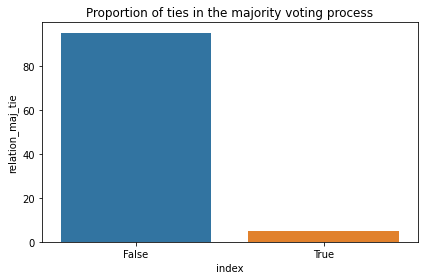

In [678]:
g = sns.barplot(
    data = pilot_results_multiple_df_agg
    .relation_maj_tie
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(),    
    x='index',
    y='relation_maj_tie',
)
g.set_title('Proportion of ties in the majority voting process')
plt.tight_layout()

#### Multiple Evidence, TE labels and probs

In [708]:
pilot_results_multiple_df_agg_scores = pd.merge(
    pilot_results_multiple_df_agg.reset_index(),
    te_df_pre_join,
    on=['reference_id', 'claim_id'],
    how='left'
)[['reference_id', 'relation_maj', 'WS_TE_probs', 'WS_TE_label', 'MALON_TE_label', 'WS_TE_id', 'MALON_TE_id']]
pilot_results_multiple_df_agg_scores.head()

,reference_id,relation_maj,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,2b3521dca65c1b040551a9e60c3c7e53b2c13929,0,"[0.0374583527, 0.2309435457, 0.7313274145]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
1,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,2,"[0, 0, 0]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
2,3d830420ab7694849eed20a4307cf44e9ee447be,1,"[0.0028231924, 0.0004741912, 0.0269695055]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
3,42a1f4408027d6da489ba6e931145f3f598cf923,0,"[0.8968318701, 0.0180348679, 0.0839994401]",SUPPORTS,SUPPORTS,0,0
4,5e9bc44ce8b4ae04f57985660ab5f880cee53315,0,"[3.5474262238, 0.0363196209, 0.5078652501]",SUPPORTS,SUPPORTS,0,0


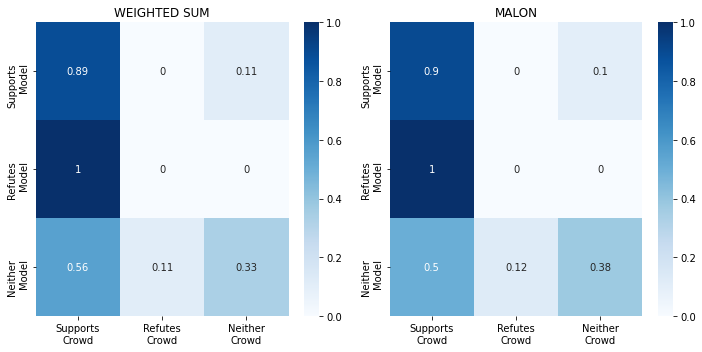

In [709]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(10,5))
cm = confusion_matrix(
    y_true = pilot_results_multiple_df_agg_scores['WS_TE_id'],
    y_pred = pilot_results_multiple_df_agg_scores['relation_maj'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0])
g.set_title('WEIGHTED SUM')
g.set_yticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_xticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

cm = confusion_matrix(
    y_true = pilot_results_multiple_df_agg_scores['MALON_TE_id'],
    y_pred = pilot_results_multiple_df_agg_scores['relation_maj'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1])
g.set_title('MALON')
g.set_yticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_xticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

In [710]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_true = pilot_results_multiple_df_agg_scores['WS_TE_id'],
    y_pred = pilot_results_multiple_df_agg_scores['relation_maj']
)
print(cr)

cr = classification_report(
    y_true = pilot_results_multiple_df_agg_scores['MALON_TE_id'],
    y_pred = pilot_results_multiple_df_agg_scores['relation_maj']
)
print(cr)

              precision    recall  f1-score   support

           0       0.53      0.89      0.67         9
           1       0.00      0.00      0.00         2
           2       0.75      0.33      0.46         9

    accuracy                           0.55        20
   macro avg       0.43      0.41      0.38        20
weighted avg       0.58      0.55      0.51        20

              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.00      0.00      0.00         2
           2       0.75      0.38      0.50         8

    accuracy                           0.60        20
   macro avg       0.45      0.42      0.41        20
weighted avg       0.60      0.60      0.56        20



In [711]:
cm = confusion_matrix(
    y_true = pilot_results_multiple_df_agg_scores['WS_TE_id'],
    y_pred = pilot_results_multiple_df_agg_scores['relation_maj']
)

cm = pd.DataFrame(cm)
cm.index = [x+' Model' for x in RELATION_LABELS[:3]]
cm.columns = [x+' Crowd' for x in RELATION_LABELS[:3]]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Crowd,Refutes Crowd,Neither Crowd,Total
Supports Model,8,0,1,9
Refutes Model,2,0,0,2
Neither Model,5,1,3,9
Total,15,1,4,20


In [712]:
pilot_results_multiple_df_agg_scores[
    ['Supports_WS_TE_prob', 'Refutes_WS_TE_prob', 'NEI_WS_TE_prob']
] = pd.DataFrame(pilot_results_multiple_df_agg_scores['WS_TE_probs'].tolist())
pilot_results_multiple_df_agg_scores.drop('WS_TE_probs', axis=1, inplace=True)
pilot_results_multiple_df_agg_scores.head()

,reference_id,relation_maj,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id,Supports_WS_TE_prob,Refutes_WS_TE_prob,NEI_WS_TE_prob
0,2b3521dca65c1b040551a9e60c3c7e53b2c13929,0,NOT ENOUGH INFO,NOT ENOUGH INFO,2,2,0.037458,0.230944,0.731327
1,2ecb2518bc116ca7cb6b48a2a949f1343d1a3808,2,NOT ENOUGH INFO,NOT ENOUGH INFO,2,2,0.000000,0.000000,0.000000
2,3d830420ab7694849eed20a4307cf44e9ee447be,1,NOT ENOUGH INFO,NOT ENOUGH INFO,2,2,0.002823,0.000474,0.026970
3,42a1f4408027d6da489ba6e931145f3f598cf923,0,SUPPORTS,SUPPORTS,0,0,0.896832,0.018035,0.083999
4,5e9bc44ce8b4ae04f57985660ab5f880cee53315,0,SUPPORTS,SUPPORTS,0,0,3.547426,0.036320,0.507865


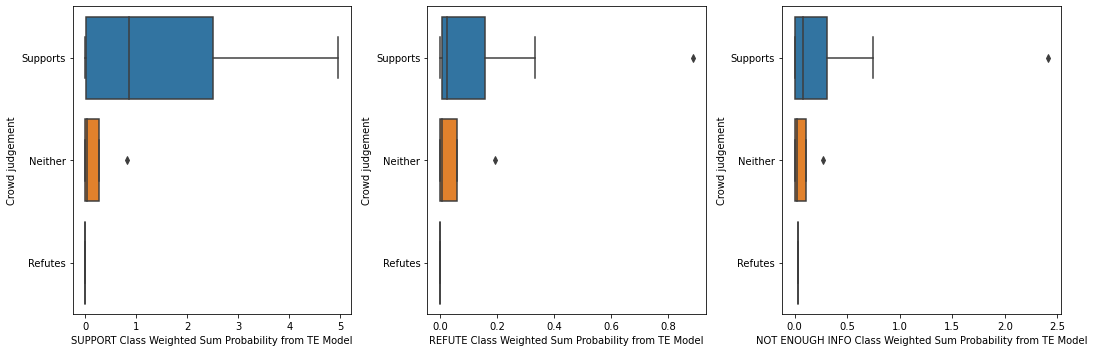

In [713]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

pilot_results_multiple_df_agg_scores['relation_maj_label'] = pilot_results_multiple_df_agg_scores['relation_maj']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=pilot_results_multiple_df_agg_scores,
    x='Supports_WS_TE_prob',
    y='relation_maj_label',
    ax=ax[0]
)
g.set(xlabel='SUPPORT Class Weighted Sum Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_multiple_df_agg_scores,
    x='Refutes_WS_TE_prob',
    y='relation_maj_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Weighted Sum Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=pilot_results_multiple_df_agg_scores,
    x='NEI_WS_TE_prob',
    y='relation_maj_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Weighted Sum Probability from TE Model',ylabel='Crowd judgement')

plt.tight_layout()
# Remember: This does not take into consideration evidence with non-positive EV score
# See how 

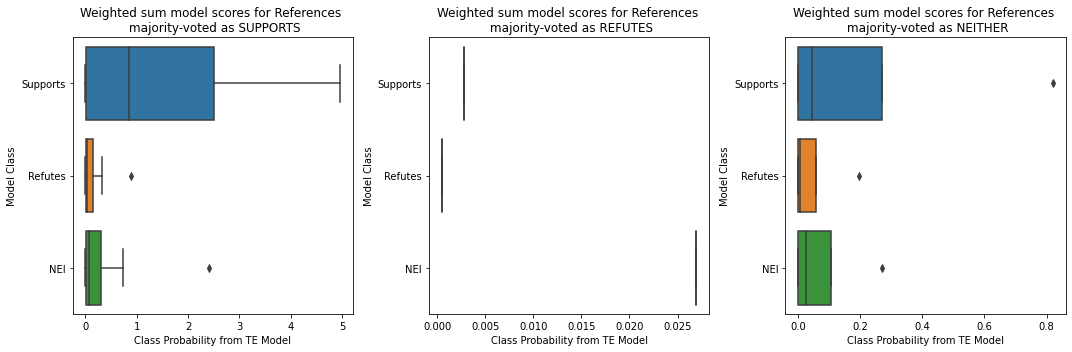

In [720]:
# These plots here are just an inverse of the plots above and illustrate the point written on the previous cell
fig, ax = plt.subplots(1,3,figsize=(15,5))

for i, cl in enumerate(['SUPPORTS','REFUTES','NEITHER']):
    g = sns.boxplot(
        data=pilot_results_multiple_df_agg_scores[
                pilot_results_multiple_df_agg_scores['relation_maj'] == i
            ][['Supports_WS_TE_prob','Refutes_WS_TE_prob','NEI_WS_TE_prob']]
            .melt(),
        y='variable',
        x='value', ax=ax[i]
    )

    g.set(
        xlabel='Class Probability from TE Model',
        ylabel='Model Class',
        yticklabels=['Supports','Refutes','NEI'],
        title=f'Weighted sum model scores for References \n majority-voted as {cl}'
    )
    
plt.tight_layout()
# Not enough data for reasonable conclusion
# Only conclusiou is that there is a slight difference between Supports and Neither, which
# The max-of-weighted-sum approach seems to explore well, given the classification performance
# seen in the confusion matrices above